# American Sign Language - Computer Vision Project

- Dataset: https://public.roboflow.com/object-detection/american-sign-language-letters
- Example Task: https://towardsdatascience.com/sign-language-recognition-with-advanced-computer-vision-7b74f20f3442

In [1]:
## Load intro from README
from pathlib import Path
from IPython.display import display, Markdown
intro = Path('config/readme_part1.md').read_text()
intro = intro.split("Example of Each letter:")[0]
display(Markdown(intro))


# computer-vision-american-sign-language

-  Last Updated: 06/03/2024

<center><img src="images/American_Sign_Language_ASL.svg" width=500px>
<p>By Psiĥedelisto - Own work, Public Domain, <a href="https://commons.wikimedia.org/w/index.php?curid=53652991">"https://commons.wikimedia.org/w/index.php?curid=53652991</a><p>
</center>

## Description

This project aims to develop a computer vision system for American Sign Language (ASL) recognition. 


### Goals 
> - **The first/primary goal is to create a model that can classify images of letters from the ASL alphabet (26-class multi-classification)**
- Create a streamlit application that will accept an image and predict which letter it is.

> - **The second, above-and-beyond goal is to use video as the input and add object detection.**

### Features

- ASL letter and word translation
- User-friendly interface
- Support for multiple hand gestures

<center><img src="images/Sign_language_alphabet_(58).png" width=500px style="border:solid black 1px"> 

<p><a href="https://commons.wikimedia.org/wiki/File:Sign_language_alphabet_(58).png">Image Source</a> </p>
<p> Raziakhatun12, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons</p>

</center>




## Data

### Source/Download
- Public Dataset from [Roboflow](https://public.roboflow.com/object-detection/american-sign-language-letters)


To download:
- Navigate to https://public.roboflow.com/object-detection/american-sign-language-letters
- Click `->` for Downloads.
- Select Format =  Multi-Label Classifiction
- Download zip to computer


### Data Details
- 26 letters of the alphabet
- J and Z are gesture-based letters and will likely be difficult to classify using static images.

- Number of Images: 1731
- Size: 416 x  416 
- Channels: 3



## Project Setup
- Imports, custom modules, and defining project filepaths.

In [2]:
import numpy as np
import tensorflow as tf

# Set the seed for NumPy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL

import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical


tf.__version__

'2.12.0'

In [3]:
# Custom functions:
%load_ext autoreload
%autoreload 2
# sys.path.append(os.path.abspath("../../"))
import custom_functions as cf
help(cf)

Help on package custom_functions:

NAME
    custom_functions

PACKAGE CONTENTS
    ann_functions
    capture_output
    fileinfo
    model_logging
    quantize_model
    utils

SUBMODULES
    capture
    logs
    quantize

FUNCTIONS
    show_code(function)
        Uses the inspect module to retrieve the source code for a function.
        Displays the code as Python-syntax Markdown code.
        
        Note: Python highlighting may not work correctly on some editors.
        
        Parameters:
        function (callable): The function for which to display the source code.
        
        Returns:
        None

FILE
    /Users/codingdojo/Documents/GitHub/_MY_PROJECTS/computer-vision-american-sign-language/custom_functions/__init__.py




In [4]:
import json, os
from pathlib import Path
from pprint import pprint

# Define filename for project config filepaths json file
FPATHS_FILE = "config/filepaths.json"
os.makedirs(os.path.dirname(FPATHS_FILE), exist_ok=True)

# Define Filepaths
FPATHS = dict(
    data={
        # Images Directoryies
        'data_dir': "./American Sign Language Letters.v1-v1.multiclass/",
        "train-images_dir": "./American Sign Language Letters.v1-v1.multiclass/train/",
        "test-images_dir": "./American Sign Language Letters.v1-v1.multiclass/test/",
        
        # Image classes as csv fiels
        "train-labels_csv": "./American Sign Language Letters.v1-v1.multiclass/train/_classes.csv",
        "test-labels_csv": "./American Sign Language Letters.v1-v1.multiclass/test/_classes.csv",
        
        # Processed versions of the above csv files
        "train-labels_processed_csv": "./American Sign Language Letters.v1-v1.multiclass/train/_classes_processed.csv",
        "test-labels_processed_csv": "./American Sign Language Letters.v1-v1.multiclass/test/_classes_processed.csv",

        },

    images={
        "banner": "images/American_Sign_Language_ASL.svg",
        
    },
    # Any images to be displayed in the app
    eda={
        "label-distrubtion-countplot_png": "images/label-distribution-countplot.png",
        "test-labels-distrubtion_png": "images/test-label-distribution-countplot.png",
        "example-images_png": "images/ed_example_letters.png",
        "lime-explanation_png": "images/lime-explanation.png",
        "lime-explanation-wrong_png":"images/lime-explanation-wrong.png",
        "lime-explanation-right_png":"images/lime-explanation-right.png",
        
    },
    modeling={
        "model_dir": "modeling/models/",
            "results_log":"modeling/nn_training.log",
            "results_log_csv":"modeling/nn_training.csv",
            "train-dataset_dir": "modeling/data/training-data-tf/",  # train_ds
            "val-dataset_dir": "modeling/data/validation-data-tf/",  # train_ds
            "test-dataset_dir": "modeling/data/testing-data-tf/",  # test_ds
            "params":"modeling/params.json",
            "label-lookup_json": "modeling/label_lookup.json",
},
    # config = {'log_fpath': "logs/nn_training.log",},
    readme = {"results_table_md": "modeling/results_table.md",
             }
)


# Use fn for local package, ds for pip version
cf.utils.create_directories_from_paths(FPATHS)
# ds.utils.create_directories_from_paths(FPATHS)

print('[i] FPATHS Dictionary:\n')
pprint(FPATHS.keys())#, indent=4)

## Save the filepaths
with open(FPATHS_FILE, "w") as f:
    json.dump(FPATHS, f)
    print(f"\n[i] Saved FPATHS to {FPATHS_FILE}")
    
# FPATHS

[i] FPATHS Dictionary:

dict_keys(['data', 'images', 'eda', 'modeling', 'readme'])

[i] Saved FPATHS to config/filepaths.json


In [5]:
## Save the filepaths
with open(FPATHS_FILE) as f:
    FPATHS = json.load(f)
    print(f"\n[i] Loaded FPATHS from {FPATHS_FILE}")
    
FPATHS.keys()


[i] Loaded FPATHS from config/filepaths.json


dict_keys(['data', 'images', 'eda', 'modeling', 'readme'])

### 🎛️ Project Params

In [6]:
## Set project-wide parameters
OVERWRITE_LOGS = True

# # Saving image params as vars for reuse
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128

## Set data split proportions
TRAIN_SPLIT = 0.7  # Proportion of data for training
VAL_SPLIT = 0.15  # Proportion of data for validation (remaining will be for test)


# Save model params
PATIENCE = 5  # For early stopping
RESTORE_BEST_WEIGHTS = True  # For early stopping
EPOCHS = 100  # Max number of epochs to run
print(f"EPOCHS TEMPORARILY SET TO {EPOCHS}")

import json
## Save model params from above to json
params = {"BATCH_SIZE":BATCH_SIZE,
          "IMG_HEIGHT":IMG_HEIGHT,
          "IMG_WIDTH":IMG_WIDTH,
          "TRAIN_SPLIT":TRAIN_SPLIT,
          "VAL_SPLIT":VAL_SPLIT,
          "PATIENCE":PATIENCE,
          "RESTORE_BEST_WEIGHTS":RESTORE_BEST_WEIGHTS,
          "EPOCHS":EPOCHS}

with open(FPATHS['modeling']['params'], "w") as f:
    json.dump(params, f)
    print(f"\n[i] Saved params to {FPATHS['modeling']['params']}")

EPOCHS TEMPORARILY SET TO 100

[i] Saved params to modeling/params.json


# Load Data

In [7]:
# Checking the contents of data folder
data_dir = FPATHS['data']['data_dir'] #"./American Sign Language Letters.v1-v1.multiclass/"
data_dir

'./American Sign Language Letters.v1-v1.multiclass/'

In [8]:
# Getting list of img file paths (ONLY, did not make recursuve so no folders)
img_files = glob.glob(data_dir+"**/*")#, recursive=True)
len(img_files)

1733

(416, 416, 3)


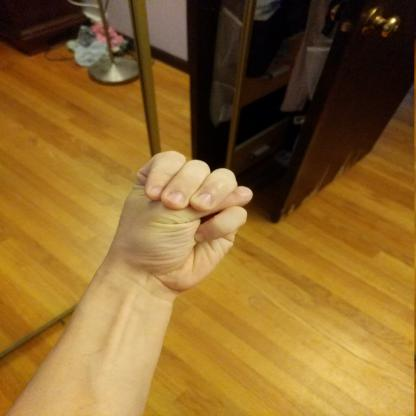

In [9]:
# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
img_data = img_to_array(img_loaded)
print(img_data.shape)
array_to_img(img_data)

### Prepare CSV of Filenames + Labels (1 per train/test)

In [10]:

# Load the CSV file
train_csv = FPATHS['data']['train-labels_csv']
df_train = pd.read_csv(train_csv, index_col='filename')

# Clean column names
df_train.columns = [c.strip() for c in df_train.columns]

# convert laels to float
df_train = df_train.astype(float)
df_train

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
filename,,,,,,,,,,,,,,,,,,,,,
U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
P12_jpg.rf.0046c1c30abbbccd31716c5b2ad835b9.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
K4_jpg.rf.00821732715c9137b8060360770ea1d8.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
W6_jpg.rf.00d19bc3a49f6469e2afa3aa92f14ff4.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
J30_jpg.rf.00d20e595026b31773ded47509545471.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A15_jpg.rf.ff648f0ba648df1d2782e75ddea0f9ba.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J3_jpg.rf.ff86dc5a870f1eadf471751c7fe11941.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A19_jpg.rf.ffe6b49b3b0683ef4eb235ec6c7eca9e.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Saving list of one-hot-encoded labels
label_cols = classes = sorted(df_train.drop(columns=['filename','filepath','label'], errors='ignore').columns)
label_cols[:10]

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

In [12]:
# Combine label columns into single column
df_train.loc[:,'label'] = df_train[label_cols].apply(lambda x: x.idxmax(), axis=1)
# display(df_train.head(2))
df_train['label'].value_counts(1).sort_index()

label
A    0.045635
B    0.025794
C    0.035714
D    0.041667
E    0.041667
F    0.039683
G    0.039683
H    0.033730
I    0.051587
J    0.051587
K    0.033730
L    0.047619
M    0.033730
N    0.039683
O    0.035714
P    0.033730
Q    0.039683
R    0.031746
S    0.045635
T    0.027778
U    0.031746
V    0.037698
W    0.037698
X    0.041667
Y    0.031746
Z    0.043651
Name: proportion, dtype: float64

In [13]:
# Save prepend folder path to image filenames
train_img_dir = FPATHS['data']['train-images_dir']

# Save label lookup dictionary
label_lookup = {i:label for i,label in enumerate(classes)}
# print( "label_lookup:\t",label_lookup)
print(f"{label_lookup = }")

# Save reverse lookup dictionary
reverse_label_lookup = {label:i for i,label in enumerate(classes)}
print(f"{reverse_label_lookup = }")

label_lookup = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}
reverse_label_lookup = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


In [14]:
## Get the filepaths and labels
df_train = df_train.reset_index(drop=False)

# Append the folder path to the filename
df_train['filepath'] = df_train.loc[:,'filename'].astype(str).map(lambda x: os.path.join(train_img_dir, x)).values
filepaths = df_train['filepath']

# Save the labels as one-hot encoded arrays
labels = df_train[label_cols].astype(float).values
filepaths[0], labels[0]

('./American Sign Language Letters.v1-v1.multiclass/train/U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg',
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0.]))

In [15]:
def prepare_labels_df(csv_fpath, img_dir, return_label_lookup=False, 
                      save_processed_csv=False, processed_csv_fpath=None,
                      save_label_lookup=False, label_lookup_fpath=None):
    
    df = pd.read_csv(csv_fpath)
    
    df = df.convert_dtypes()
    df.columns = [c.strip() for c in df.columns]

    # Save label columns
    label_cols = classes = sorted(df.drop(columns=['filename','filepath','label'], errors='ignore').columns)
    # df = df.set_index('filename')
    df[label_cols] = df[label_cols].astype(float)
    
    # Combine labels into single column for EDA
    df.loc[:,'label'] = df[label_cols].apply(lambda x: x.idxmax(), axis=1)
    
    # df = df.reset_index(drop=False)
    
    # Save prepend folder path to image filenames
    df['filepath'] = df.loc[:,'filename'].astype(str).map(lambda x: os.path.join(img_dir, x))
    
    
    if return_label_lookup | save_label_lookup:
        # Save label lookup dictionary
        label_lookup = {i:label for i,label in enumerate(classes)}
    
    if save_label_lookup:
        with open(label_lookup_fpath, "w") as f:
            json.dump(label_lookup, f)
            print(f"\n[i] Saved label lookup to {label_lookup_fpath}")

    
    if save_processed_csv:
        # Save processed csv
        df.to_csv(processed_csv_fpath, index=False)
        print(f"\n[i] Saved processed csv to {processed_csv_fpath}")
    
    if return_label_lookup:
        print("- DataFrame and label lookup dictionary returned.")
        return df, label_lookup
    
    else:
        print("- DataFrame only returned.")
        return df

In [16]:
# Load training data and labels
df_train, label_lookup = prepare_labels_df(FPATHS['data']['train-labels_csv'], 
                             FPATHS['data']['train-images_dir'], 
                             save_label_lookup=True, label_lookup_fpath=FPATHS['modeling']['label-lookup_json'],
                             save_processed_csv=True, processed_csv_fpath=FPATHS['data']['train-labels_processed_csv'],
                             return_label_lookup=True)
df_train.head(2)

print(f"- Label Lookup Dictionaries:")
print(f"\t{label_lookup = }")
reverse_label_lookup = {label:i for i,label in label_lookup.items()}
print(f"\t{reverse_label_lookup = }")


[i] Saved label lookup to modeling/label_lookup.json

[i] Saved processed csv to ./American Sign Language Letters.v1-v1.multiclass/train/_classes_processed.csv
- DataFrame and label lookup dictionary returned.
- Label Lookup Dictionaries:
	label_lookup = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}
	reverse_label_lookup = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


In [17]:
# # Load training data and labels
# df_test = prepare_labels_df(FPATHS['data']['test-labels_csv'], 
#                              FPATHS['data']['test-images_dir'], 
#                              save_label_lookup=False, 
#                              save_processed_csv=True, processed_csv_fpath=FPATHS['data']['test-labels_processed_csv'],
#                              return_label_lookup=False)
# display(df_test.head(2))

### Preprocess Images

In [18]:
# Function to load and preprocess images for dataset
def load_image(filename, label, img_height=IMG_HEIGHT, img_width=IMG_WIDTH,
               rescale=False):
    """
    Loads and preprocesses an image from the given filename.

    Args:
        filename (str): The path to the image file.
        label: The label associated with the image.
        img_height (int): The desired height of the image (default: IMG_HEIGHT).
        img_width (int): The desired width of the image (default: IMG_WIDTH).
        rescale (bool): Whether to rescale the image values between 0 and 1 (default: False).

    Returns:
        img: The preprocessed image.
        label: The label associated with the image.
    """
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [img_height, img_width])
    
    if rescale:
        img = img / 255.0
    
    return img, label

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB


[i] Preview Image (Training Data)
- Label (Category): U
- Label (OHE): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0.]


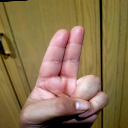

- Image Shape: (128, 128, 3)


In [19]:
# Dispay an example image
i = 0
# filepaths = df_train['filepath']
# labels = df_train[label_cols].astype(float).values

def preview_image(filepaths, labels, i, label_lookup, title=""):
    """
    Preview an image along with its label and other information.

    Parameters:
    - filepaths (list): List of filepaths for the images.
    - labels (list): List of labels for the images.
    - i (int): Index of the image to preview.
    - label_lookup (dict): Dictionary mapping label indices to their corresponding categories.
    - title (str, optional): Title for the preview image. Defaults to an empty string.

    Returns:
    None
    """
    ex_img, ex_label = load_image(filepaths[i], labels[i])
    
    print("\n[i] Preview Image"+ title)
    print(f"- Label (Category): {label_lookup[np.argmax(ex_label)]}")
    print(f"- Label (OHE): {ex_label}")

    display(array_to_img(ex_img))
    print(f"- Image Shape: {ex_img.shape}")
    
    
    
# Preview an example from training and testing data
preview_image(filepaths=df_train['filepath'].values, labels=df_train[label_cols].values, i=0, label_lookup=label_lookup,
              title=" (Training Data)")

### EDA

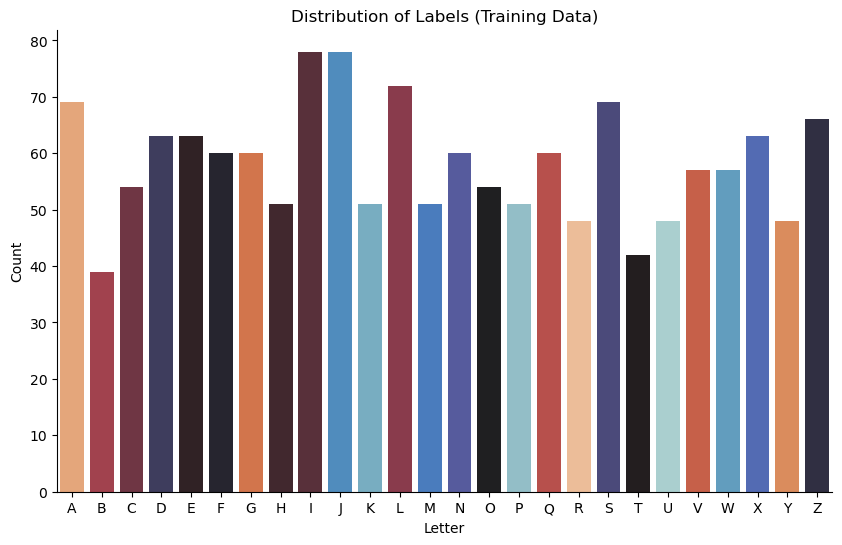

In [20]:
def plot_label_distribution(eda_df, x='label', title="Distribution of Labels (Training Data)", xlabel="Letter", ylabel="Count",
                            label_lookup=None, save_path=None):
    """
    Plots the distribution of labels in the training data.

    Parameters:
    - eda_df (DataFrame): The DataFrame containing the data for analysis.
    - x (str): The column name representing the labels. Default is 'label'.
    - title (str): The title of the plot. Default is "Distribution of Labels (Training Data)".
    - xlabel (str): The label for the x-axis. Default is "Letter".
    - ylabel (str): The label for the y-axis. Default is "Count".
    - label_lookup (dict): A dictionary mapping label values to their corresponding names. Default is None.
    - save_path (str): The file path to save the plot. Default is None.

    Returns:
    - fig (Figure): The matplotlib Figure object.
    - ax (Axes): The matplotlib Axes object.
    """
    if label_lookup is None:
        classes = sorted(eda_df[x].unique())
    else:
        classes = sorted(label_lookup.values())
    
    # Plot Distrubtion of Labels in Training Data
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.countplot(data=eda_df, x=x,order=classes,#label_lookup.values(),
                hue=x, dodge=False,palette=sns.color_palette("icefire",n_colors=len(classes)),
                ax=ax)
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', transparent=False)
        
    return fig, ax
        
fig, ax = plot_label_distribution(df_train, title="Distribution of Labels (Training Data)", save_path=FPATHS['eda']['label-distrubtion-countplot_png'],
                                  label_lookup=label_lookup)


#### Display Example of Each

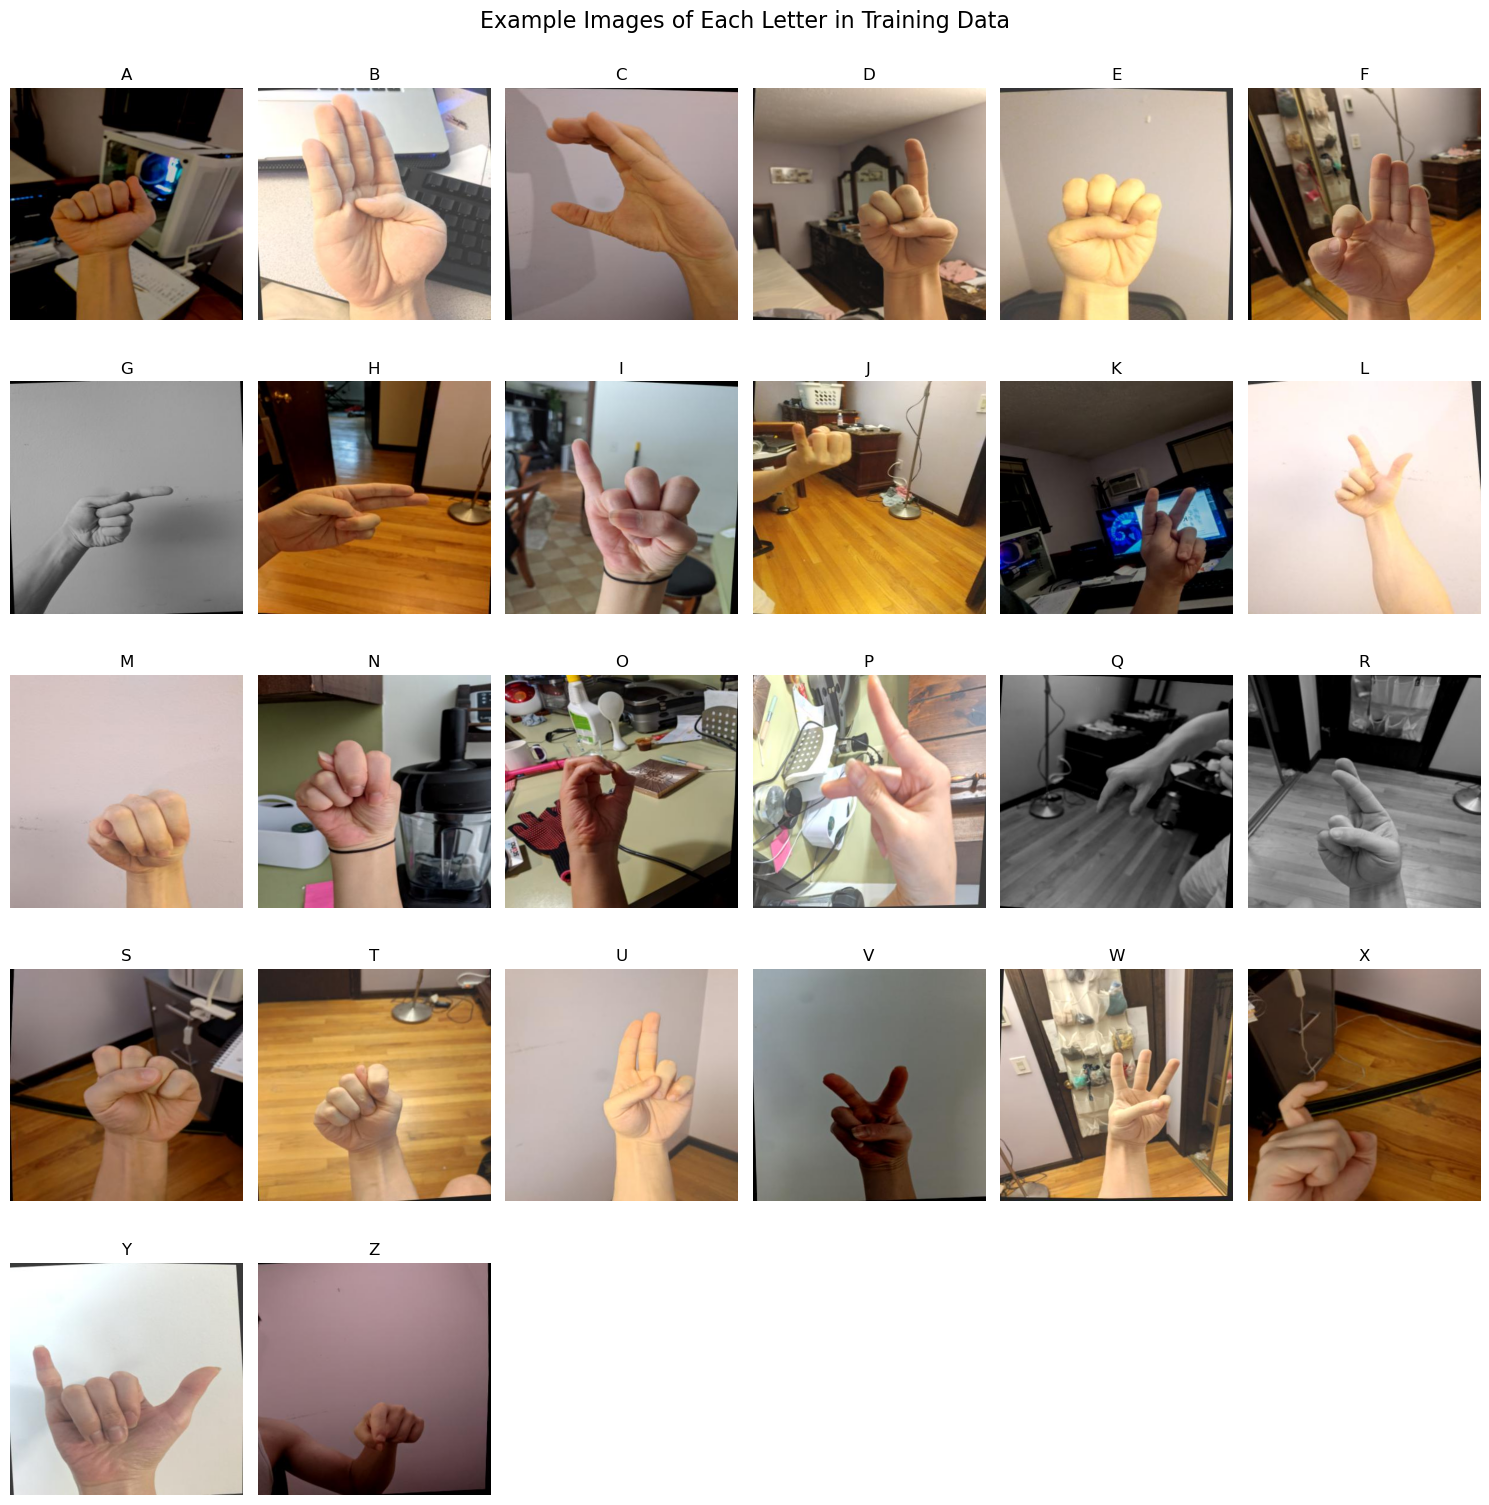

In [21]:
### Plot example of each letter
import os
# os.makedirs("images", exist_ok=True)

def plot_example_images(eda_df,label_col='label',fpath_col = "filepath", ncols = 6,figsize=(15,15),
                        save_path=None, suptitle=None, suptitle_y=1.02, suptitle_fontsize=16):
    """
    Plot example images from a DataFrame.
    
    Parameters:
    - eda_df (DataFrame): The DataFrame containing the image data.
    - label_col (str): The column name in the DataFrame that contains the labels.
    - fpath_col (str): The column name in the DataFrame that contains the file paths to the images.
    - ncols (int): The number of columns in the plot grid.
    - figsize (tuple): The size of the figure (width, height) in inches.
    - save_path (str): The file path to save the figure. If None, the figure will not be saved.
    - suptitle (str): The title of the figure.
    - suptitle_y (float): The y-coordinate of the suptitle.
    - suptitle_fontsize (int): The font size of the suptitle.
    
    Returns:
    - fig (Figure): The matplotlib Figure object.
    - axes (array of Axes): The array of Axes objects.
    """
    
    # Save labels and determine rows
    unique_labels = sorted(eda_df[label_col].unique())
    nrows = len(unique_labels)//ncols + 1
    
    
    ## Create figure and flatten axes
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    axes = axes.flatten()
    
    # Plot example of each
    for i, label in enumerate(unique_labels):
        # Selet random example of label
        fpath = eda_df.loc[ eda_df[label_col]==label,fpath_col].sample(1).values[0]
        
        # Load and plot the iamge
        loaded = plt.imread(fpath)
        axes[i].imshow(loaded)
        axes[i].set_title(label)
        axes[i].axis('off')
        
    # Remove unused axes    
    axes_labels_diff =  len(axes) - len(unique_labels)
    if axes_labels_diff>0:
        for ax in axes[-axes_labels_diff:]:
            fig.delaxes(ax=ax)   
    
    # Tweak layout
    fig.tight_layout()
    if suptitle is not None:
        fig.suptitle(suptitle, y=suptitle_y, fontsize=suptitle_fontsize)
    
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', transparent=False)
        
    return fig, axes




fig, axes = plot_example_images(df_train, save_path=FPATHS['eda']['example-images_png'],
                                suptitle="Example Images of Each Letter in Training Data")

### Construct Train/Test/Val Tensorflow Datasets

In [22]:
## Load and preprocess images for dataset
filepaths = df_train['filepath'].values
labels = df_train[label_cols].values
dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))

# Shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=False, seed=42)

# Demonstrating the dataset starts as filepaths and labels
dataset.take(1).get_single_element()

(<tf.Tensor: shape=(), dtype=string, numpy=b'./American Sign Language Letters.v1-v1.multiclass/train/Z5_jpg.rf.544842f2941835d4960bd18e6ef49bca.jpg'>,
 <tf.Tensor: shape=(26,), dtype=float64, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1.])>)

In [23]:
## Map the load_image function to the dataseta
dataset = dataset.map(lambda x,y: load_image(x,y),
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Demonstrating the dataset now contains images and labels
dataset.take(1).get_single_element()

2024-06-05 15:30:29.806036: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[  3.3416748 ,   7.9247437 ,   4.0653687 ],
         [  6.633606  ,   9.110962  ,   5.970337  ],
         [  5.312256  ,   9.07135   ,   5.493225  ],
         ...,
         [  7.        ,   7.        ,   5.        ],
         [  4.        ,   8.        ,   7.        ],
         [  6.7890625 ,   7.0703125 ,   7.        ]],
 
        [[  9.078918  ,   3.024231  ,   1.913269  ],
         [  9.598511  ,   3.5438232 ,   0.96569824],
         [ 13.777283  ,   7.722595  ,   5.14447   ],
         ...,
         [  7.        ,   7.        ,   5.        ],
         [  4.        ,   8.        ,   7.        ],
         [  6.7890625 ,   7.0703125 ,   7.        ]],
 
        [[127.038025  , 107.68646   , 109.3349    ],
         [149.4851    , 130.13354   , 131.78198   ],
         [168.97876   , 149.6272    , 151.27563   ],
         ...,
         [  7.        ,   7.        ,   5.        ],
         [  4.        ,   8.        ,   7.      

In [24]:
# # Batch and prefetch the datasets
# train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# # Shuffle the trainin data
# train_dataset = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), 
#                                       reshuffle_each_iteration=True, 
#                                       # seed=42
#                                       )


# # Use the datasets
# for images, labels in train_dataset.take(1):
#     print(f"Train batch - images: {images.shape}, labels: {labels.shape}")
    
# for images, labels in val_dataset.take(1):
#     print(f"Val batch - images: {images.shape}, labels: {labels.shape}")
    
    
# for images, labels in test_dataset.take(1):
#     print(f"Test batch - images: {images.shape}, labels: {labels.shape}")
    

In [25]:
# Determine split sizes
total_size = len(list(dataset))  # Note: converting to list to get the length
train_size = int(TRAIN_SPLIT * total_size)
val_size = int(VAL_SPLIT * total_size)
test_size = total_size - train_size - val_size
print(f"{train_size=}, {test_size=}, {val_size=}")

# Split the dataset
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

# Cache the dataset for faster access
train_dataset = train_dataset.cache()
val_dataset = val_dataset.cache()
test_dataset = test_dataset.cache()

# Shuffle the training data before batching
train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset),
                                      reshuffle_each_iteration=True)

# Batch and prefetch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Use the datasets
for images, labels in train_dataset.take(1):
    print(f"Train batch - images: {images.shape}, labels: {labels.shape}")

for images, labels in val_dataset.take(1):
    print(f"Val batch - images: {images.shape}, labels: {labels.shape}")

for images, labels in test_dataset.take(1):
    print(f"Test batch - images: {images.shape}, labels: {labels.shape}")

train_size=1058, test_size=228, val_size=226
Train batch - images: (32, 128, 128, 3), labels: (32, 26)
Val batch - images: (32, 128, 128, 3), labels: (32, 26)


2024-06-05 15:30:31.308562: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Test batch - images: (32, 128, 128, 3), labels: (32, 26)


2024-06-05 15:30:31.597175: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [26]:
## Save datasets to disk
train_dataset_fpath = FPATHS['modeling']['train-dataset_dir']
tf.data.Dataset.save(train_dataset, train_dataset_fpath, compression="GZIP")

val_dataset_fpath = FPATHS['modeling']['val-dataset_dir']
tf.data.Dataset.save(val_dataset, val_dataset_fpath,compression="GZIP")

test_dataset_fpath = FPATHS['modeling']['test-dataset_dir']
tf.data.Dataset.save(test_dataset, test_dataset_fpath,compression="GZIP")
train_dataset_fpath, val_dataset_fpath, test_dataset_fpath

('modeling/data/training-data-tf/',
 'modeling/data/validation-data-tf/',
 'modeling/data/testing-data-tf/')

In [27]:
## Check for dataset files that are too large
dataset_files_df = cf.fileinfo.list_files_in_directory(Path(train_dataset_fpath).parent)
display(dataset_files_df)
print(f"- [i] There are ({dataset_files_df['Is Large File'].sum()}) large files in the dataset directory.")

,Name,File Type,File Type Icon,Size,Creation Date,Modification Date,Absolute Path,Size (MB),Is Large File
0,snapshot.metadata,.metadata,🧠,0.00 MB,2024-06-05 15:30:47,2024-06-05 15:30:47,modeling/data/validation-data-tf/snapshot.meta...,0.000038,False
1,dataset_spec.pb,.pb,🧠,0.00 MB,2024-06-05 15:30:44,2024-06-05 15:30:44,modeling/data/validation-data-tf/dataset_spec.pb,0.000062,False
2,00000000.snapshot,.snapshot,🧠,21.00 MB,2024-06-05 12:54:16,2024-06-05 12:54:16,modeling/data/validation-data-tf/5362301671640...,21.002746,False
3,00000000.snapshot,.snapshot,🧠,21.00 MB,2024-06-05 13:25:40,2024-06-05 13:25:40,modeling/data/validation-data-tf/1641050072274...,21.002746,False
4,00000000.snapshot,.snapshot,🧠,21.00 MB,2024-06-05 14:13:32,2024-06-05 14:13:32,modeling/data/validation-data-tf/1314830730214...,21.002746,False
5,00000000.snapshot,.snapshot,🧠,21.00 MB,2024-06-05 14:31:25,2024-06-05 14:31:25,modeling/data/validation-data-tf/4328479231300...,21.002746,False
6,00000000.snapshot,.snapshot,🧠,21.00 MB,2024-06-05 14:17:07,2024-06-05 14:17:07,modeling/data/validation-data-tf/1053489872805...,21.002746,False
7,00000000.snapshot,.snapshot,🧠,21.00 MB,2024-06-05 13:48:26,2024-06-05 13:48:26,modeling/data/validation-data-tf/1680803935249...,21.002746,False
8,00000000.snapshot,.snapshot,🧠,21.00 MB,2024-06-05 13:34:37,2024-06-05 13:34:37,modeling/data/validation-data-tf/1822748562265...,21.002746,False
9,00000000.snapshot,.snapshot,🧠,21.00 MB,2024-06-05 15:11:17,2024-06-05 15:11:17,modeling/data/validation-data-tf/5516737006369...,21.002746,False


- [i] There are (0) large files in the dataset directory.


In [28]:
# dataset_files_df['Is Large File'].sum()

## Modeling Functions

#### `def get_callbacks`

In [29]:


def get_callbacks(monitor='val_accuracy', patience=PATIENCE, #15,
                  start_from_epoch=3, restore_best_weights=RESTORE_BEST_WEIGHTS):
    """
    Returns a list of callbacks for training a model.

    Parameters:
    - monitor (str): The metric to monitor. Default is 'val_accuracy'.
    - patience (int): The number of epochs with no improvement after which training will be stopped. Default is 15.
    - start_from_epoch (int): The epoch from which to start counting the patience. Default is 3.
    - restore_best_weights (bool): Whether to restore the weights of the best epoch. Default is False.

    Returns:
    - callbacks (list): A list of callbacks to be used during model training.
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience,start_from_epoch=start_from_epoch,
                                                      monitor=monitor,
                                                      restore_best_weights=restore_best_weights, verbose=1)
    return [early_stopping]




###  New Custom Eval Function: 
- `custom_evaluate_classification_network` (for Notebook use only)

> With 26 classes, it is difficult to scan the performance for each class visually. Adding code to convert results to a datafarme and use pandas styling to visualize

- added new `get_results_df` to custom_functions

In [30]:
def custom_evaluate_classification_network(model, X_test, history=None, figsize=(15,15), target_names=None,
                                            #  as_frame=True, 
                                             frame_include_macro_avg=True, frame_include_support=False,
                                             display_bar=False, bar_subset_cols = ['recall','precision','f1-score'], 
                                             conf_matrix_text_kws={'fontsize': 'x-small'},
                                             return_figs= True, return_str_report=True):
    """
    Evaluate a classification model on a test dataset.

    Parameters:
    - model: The trained classification model.
    - X_test: The test dataset.
    - history: The training history of the model (optional).
    - figsize: The size of the figure for plotting the evaluation results (default: (15, 15)).
    - target_names: The names of the target classes (default: None).
    - as_frame: Whether to return the evaluation results as a pandas DataFrame (default: True).
    - frame_include_macro_avg: Whether to include macro average metrics in the DataFrame (default: False).
    - frame_include_support: Whether to include support values in the DataFrame (default: False).
    - display_bar: Whether to display the evaluation results as a styled bar chart (default: True).

    Returns:
    - results_dict: A dictionary containing the evaluation results.
    """
    if target_names is None:
        # label_lookup is in the global scope
        target_names = label_lookup.values()
        
    results_dict = cf.evaluate_classification_network(model,
                                                      X_test=X_test,history=history, figsize=figsize,
                                                # Set output to produce a dataframe (no option)
                                                  output_dict=True, as_frame=True,
                                                  target_names=target_names,
                                                  return_fig_conf_matrix=return_figs,
                                                  return_fig_history=return_figs,
                                                    frame_include_macro_avg=frame_include_macro_avg, 
                                                    frame_include_support=frame_include_support,
                                                    values_format=".2f",
                                                    conf_matrix_text_kws=conf_matrix_text_kws,
                                                    return_str_report=return_str_report)
    
    if isinstance(results_dict, tuple):
        results_dict, fig_dict = results_dict
        # if isinstance(results_dict, dict):
        #     class_results = results_dict['test']['results-classes']
        #     overall_results = results_dict['test']['results-overall']
        # else:
        #     class_results = results_dict['test']['results-classes']
        #     overall_results = None
        #     # print(results_dict)
    else:
        raise Exception("Results dict not a tuple")
    # elif isinstance(results_dict, dict):
    #     class_results = results_dict['test']['results-classes']
    #     overall_results = results_dict['test']['results-overall']:
        
    return_list = [results_dict]
    
    if display_bar:
        try:
            plot_data = results_dict['test']['results-classes']
            display(plot_data.style.bar(subset=bar_subset_cols, color='#5fba7d').format(formatter= lambda x: f"{x:.2f}").set_caption("Test Data"))
        except:
            display(results_dict)
        
    if return_figs:
        return results_dict, fig_dict
    return results_dict

In [31]:
import datetime as dt

def fit_log_model(model, train_dataset, val_dataset, test_dataset, epochs=EPOCHS, patience=PATIENCE, fit_kws={}, callback_kws={},
                  save_results=True, record_inference_speed=True, model_directory='modeling/models/'):
    """
    Fits a log model to the given datasets and returns the model results.

    Args:
        model: The log model to be fitted.
        train_dataset: The training dataset.
        val_dataset: The validation dataset.
        test_dataset: The test dataset.
        epochs: The number of epochs to train the model (default: EPOCHS).
        patience: The number of epochs with no improvement after which training will be stopped (default: PATIENCE).
        fit_kws: Additional keyword arguments to be passed to the `fit` method of the model (default: {}).
        callback_kws: Additional keyword arguments to be passed to the `get_callbacks` function (default: {}).
        save_results: Whether to save the model results (default: True).
        record_inference_speed: Whether to record the inference speed (default: True).
        model_directory: The directory to save the model files (default: 'modeling/models/').

    Returns:
        A dictionary containing the model, history, classification results, overall results, result figures, and classification report.
    """
    
    # Save start time
    start_time = dt.datetime.now()
    
    # Get callbacks for early stopping
    callbacks = get_callbacks(patience=patience, **callback_kws)
    
    # Train the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, verbose=1,
                        callbacks=callbacks, **fit_kws)
    
    # Calculate the time taken for training
    fit_time = dt.datetime.now() - start_time
    
    if record_inference_speed:
        # Record inference speed
        start_inference = dt.datetime.now()
        preds = model.predict(test_dataset)
        inference_time = dt.datetime.now() - start_inference
        inference_datasize = len(test_dataset)
        print(f"\nInference Speed: {inference_time.seconds:02d}.{inference_time.microseconds:.3f} seconds ({inference_time}) for {inference_datasize} batches.")
    
    # Evaluate the model
    results_frames, results_figs = custom_evaluate_classification_network(model, X_test=test_dataset, history=history, figsize=(15,15),
                                                 target_names=label_lookup.values(), display_bar=True,
                                                 frame_include_macro_avg=True, frame_include_support=False)
    # If results_frames is a dictionary, then it contains the test results
    if isinstance(results_frames, dict):
        class_results = results_frames['test']['results-classes']
        overall_results = results_frames['test']['results-overall']
        
        # TEMP
        # print(results_figs['test'])
        classification_report = results_figs['test']['classification_report']
    else:
        class_results = results_frames
        overall_results = None

    if overall_results is not None:
        print("\nOverall Results:")
        display(overall_results)
    
    # Create a dictionary with model results
    model_results = dict(model=model, history=results_figs['history'], results_classes=class_results,
                results_overall=overall_results, 
                result_figs=results_figs,
                classification_report=classification_report
                )

    # Start saving log details
    log_info = dict(start_time=start_time, name=model.name,
                    fit_time=fit_time,
                    inference_time=inference_time,
                    inference_size=inference_datasize,
                    results_overall=overall_results, 
                    model_filepaths=None)
        
    if save_results:
        # Save model results
        model_filepaths = cf.logs.save_model_results(model_results, model_directory=model_directory,
                                             model_save_format="tf")
        log_info['model_filepaths'] = model_filepaths
        model_results['model_filepaths'] = model_filepaths
        
    cf.logs.log_nn_details(**log_info)#start_time, model.name, fit_time, overall_results)
        
    return model_results

In [32]:
# # Set up logging
# import logging
# import time
# import datetime as dt

# import logging

# def initialize_logs(log_file='logs/nn_training.log', overwrite_logs=True,
#                     log_header=";start_time;name;fit_time;metrics;model_filepaths"):
#     """
#     Initializes the logging configuration and sets up the log file.

#     Parameters:
#     log_file (str): The path to the log file. Default is 'logs/nn_training.log'.
#     overwrite_logs (bool): If True, the log file will be overwritten. If False, new logs will be appended to the existing file. Default is True.
#     log_header (str): The header to be written in the log file. Default is ";start_time;name;fit_time;metrics;model_filepaths".

#     Returns:
#     None
#     """
    
#     if overwrite_logs:
#         filemode = "w"
#         force = True
#     else:
#         filemode = 'a'
#         force = False
        
#     logging.basicConfig(filename=log_file, level=logging.INFO, filemode=filemode, force=force)
#     logging.info(log_header)
    


# # Function to log neural network details
# def log_nn_details(start_time, name, fit_time, results_overall, model_filepaths=None, sep=";", **kwargs):
#     """
#     Logs the details of a neural network model.

#     Parameters:
#     - start_time (datetime): The start time of the model training.
#     - name (str): The name of the model.
#     - fit_time (float): The time taken to fit the model.
#     - results_overall (pandas.DataFrame or dict): The overall results of the model evaluation.
#     - model_filepaths (dict or None): The filepaths of the model files, if available.
#     - sep (str): The separator used to format the log information.
#     - **kwargs: Additional keyword arguments.

#     Returns:
#     None
#     """

#     if model_filepaths is not None:
#         fpaths_dict = model_filepaths
#     else:
#         fpaths_dict = "N/A"

#     # Record results (except for filepaths)
#     try:
#         metrics = results_overall.loc['macro avg'].to_dict()
#     except:
#         metrics = results_overall

#     info = f"{sep}{start_time.strftime('%m/%d/%Y %T')}{sep}{name}{sep}{fit_time}{sep}{metrics}{sep}{fpaths_dict}"

#     ## Log Info
#     logging.info(info)
    


# Models

In [33]:
# Iniialize Logs and save essential filepaths
log_file = FPATHS['modeling']['results_log']
model_dir = FPATHS['modeling']['model_dir']

cf.logs.initialize_logs(log_file, overwrite_logs=True)
cf.logs.parse_log_file(log_file)

,INFO:root:,start_time,name,fit_time



[i] Saved parsed logs to modeling/nn_training.csv


,Start Time,Name,Fit Time


## Model 1 

- Model 1 is a baseline model, whos architecture is taken from a towards data science blog post on performing image classification with Amerian Sign Language.
    - from https://towardsdatascience.com/sign-language-recognition-with-advanced-computer-vision-7b74f20f3442


In [34]:
# from tensorflow
def make_model(name='towards-data-science',show_summary=False, use_schedule=False):
    """
    Baseline CNN model for image classification.
    Model Architecture adapted from https://towardsdatascience.com/sign-language-recognition-with-advanced-computer-vision-7b74f20f3442
    """
    model = models.Sequential(name=name)
    model.add(layers.Rescaling(1./255 , input_shape = (IMG_HEIGHT,IMG_WIDTH,3)))
    
    model.add(layers.Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' ))#, input_shape = (28,28,1)))
    
    model.add(layers.BatchNormalization())
    
    model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(layers.Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.BatchNormalization())
    
    model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(layers.Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    
    model.add(layers.BatchNormalization())
    
    model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    
    # Final layers
    model.add(layers.Flatten())
    model.add(layers.Dense(units = 512 , activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units = len(label_lookup   ) , activation = 'softmax'))
    model.compile(optimizer = tf.keras.optimizers.legacy.Adam() , loss = 
                  tf.keras.losses.CategoricalCrossentropy(),
                  metrics = ['accuracy'])
    if show_summary:
        model.summary()
    return model


In [35]:

# Demonstrate model architecture
model_name = "towards-data-science-blog"
model = make_model(name = model_name, show_summary=True)

Model: "towards-data-science-blog"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 75)      2100      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 75)     300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 64, 6

### Leveraging ChatGPT to Help Expand Narrative

In [36]:
# from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAI

def get_llm_reponse(input_text, context="", temperature=0.1):
    prompt =PromptTemplate.from_template( " You are a helpful data scientist AI who is assistint a data scientist with documenting their project. "
    " They want to provide clear and easy-to-read explanations that are digestable by hiring managers."                                          
    " Do not make anything up, and do not include any information that is not in the project. "
    " Help me with the following question:\n{input} Use the context below to help answer,if provided:\n{context}")
    llm = OpenAI(temperature=temperature, streaming=False, max_tokens=2000)
    chain = prompt | llm | StrOutputParser()
    
    return chain.invoke({'input':input_text,
                         'context':context})

# Need to capture model summary to feed it into chatgpt
def capture_model_summary(model, verbose=False):
    with cf.capture.capture_output() as output:
        model.summary()
    value = output.getvalue()
    
    if verbose:
        print("Captured Output:\n\n")
        print(value)
    return value


# def get_model_explanation(model, q='Simplify the explanation for the layers used in this model. Do not include the names or parameter #s.',temperature=0.1):
#     # Using chatgpt for fleshing out narrative
#     summary = capture_model_summary(model)
#     response = get_llm_reponse(q, context=output.getvalue(), temperature=temperature)
#     return response

In [37]:
# # Using chatgpt for fleshing out narrative
# print(get_model_explanation(model))
model1_summary = capture_model_summary(model)
response = get_llm_reponse("""Simplify the explanation for the layers used in this model. Do not include the names or parameter #s.
                           """, context=model1_summary,
                           temperature=0.1)
print(response)


The model used in this project consists of several layers, each with a specific function. The first layer, "rescaling", is used to normalize the input data to a range of 0-1. This helps improve the performance of the model.

The next layer, "conv2d", is a convolutional layer that applies a filter to the input image to extract features. This layer has 75 filters, each with a size of 3x3.

The "batch_normalization" layer is used to normalize the output of the previous layer, which helps improve the stability and performance of the model.

The "max_pooling2d" layer reduces the size of the output from the previous layer by taking the maximum value from each 2x2 block of pixels. This helps reduce the number of parameters in the model and prevents overfitting.

The next set of layers, "conv2d_1", "dropout", and "batch_normalization_1", perform similar functions as the previous layers, but with different parameters and filters.

The final set of layers, "flatten", "dense", "dropout_1", and "

## Model 1 (Towards Data Science)

>The model below consists of several layers that are designed to process and extract features from the input data. These layers include convolutional layers, batch normalization layers, max pooling layers, dropout layers, and dense layers.

- The convolutional layers (Cond2D) are responsible for extracting features from the input images by applying filters to the image. These filters are learned during the training process and help the model to identify patterns and features in the images.

- The BatchNormalization layers help to normalize the input data by adjusting the mean and variance of each feature. This helps to improve the stability and performance of the model.

- The MaxPooling layers reduce the spatial size of the input data by selecting the maximum value from a specific region. This helps to reduce the number of parameters and prevent overfitting.

- The Dropout layers randomly drop a certain percentage of neurons during training, which helps to prevent overfitting and improve the generalization ability of the model.

- The Dense layers are fully connected layers that take the extracted features from the previous layers and use them to make predictions. These layers have a large number of parameters and are responsible for the final output of the model.



Epoch 1/100
34/34 [==============================] - 4s 93ms/step - loss: 4.9222 - accuracy: 0.1248 - val_loss: 4.3939 - val_accuracy: 0.0265
Epoch 2/100
34/34 [==============================] - 3s 75ms/step - loss: 2.3901 - accuracy: 0.3648 - val_loss: 5.2873 - val_accuracy: 0.0487
Epoch 3/100
34/34 [==============================] - 3s 75ms/step - loss: 1.5446 - accuracy: 0.5699 - val_loss: 7.4826 - val_accuracy: 0.0531
Epoch 4/100
34/34 [==============================] - 3s 78ms/step - loss: 0.9137 - accuracy: 0.7325 - val_loss: 6.4236 - val_accuracy: 0.0442
Epoch 5/100
34/34 [==============================] - 3s 75ms/step - loss: 0.4277 - accuracy: 0.8724 - val_loss: 6.3758 - val_accuracy: 0.0796
Epoch 6/100
34/34 [==============================] - 3s 75ms/step - loss: 0.4448 - accuracy: 0.8790 - val_loss: 6.7741 - val_accuracy: 0.0575
Epoch 7/100
34/34 [==============================] - 3s 74ms/step - loss: 0.3003 - accuracy: 0.9008 - val_loss: 6.5640 - val_accuracy: 0.0841
Epoch 

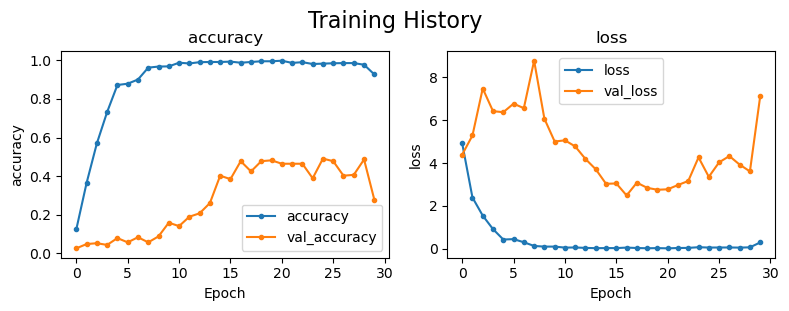


- Evaluating Test Data:
8/8 [==============================] - 0s 49ms/step - loss: 3.4967 - accuracy: 0.4342
{'loss': 3.496675968170166, 'accuracy': 0.43421053886413574} 

--------------------------------------------------------------------------------
 Classification Metrics: Test Data 
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           A       0.27      0.43      0.33         7
           B       0.50      0.20      0.29         5
           C       0.40      0.50      0.44         8
           D       1.00      0.42      0.59        12
           E       0.33      0.33      0.33         6
           F       0.00      0.00      0.00         7
           G       0.75      0.60      0.67        10
           H       0.33      0.80      0.47         5
           I       0.42      0.56      0.48         9
           J       0.65      0.81      0.72        16
           K       0.60      0.43

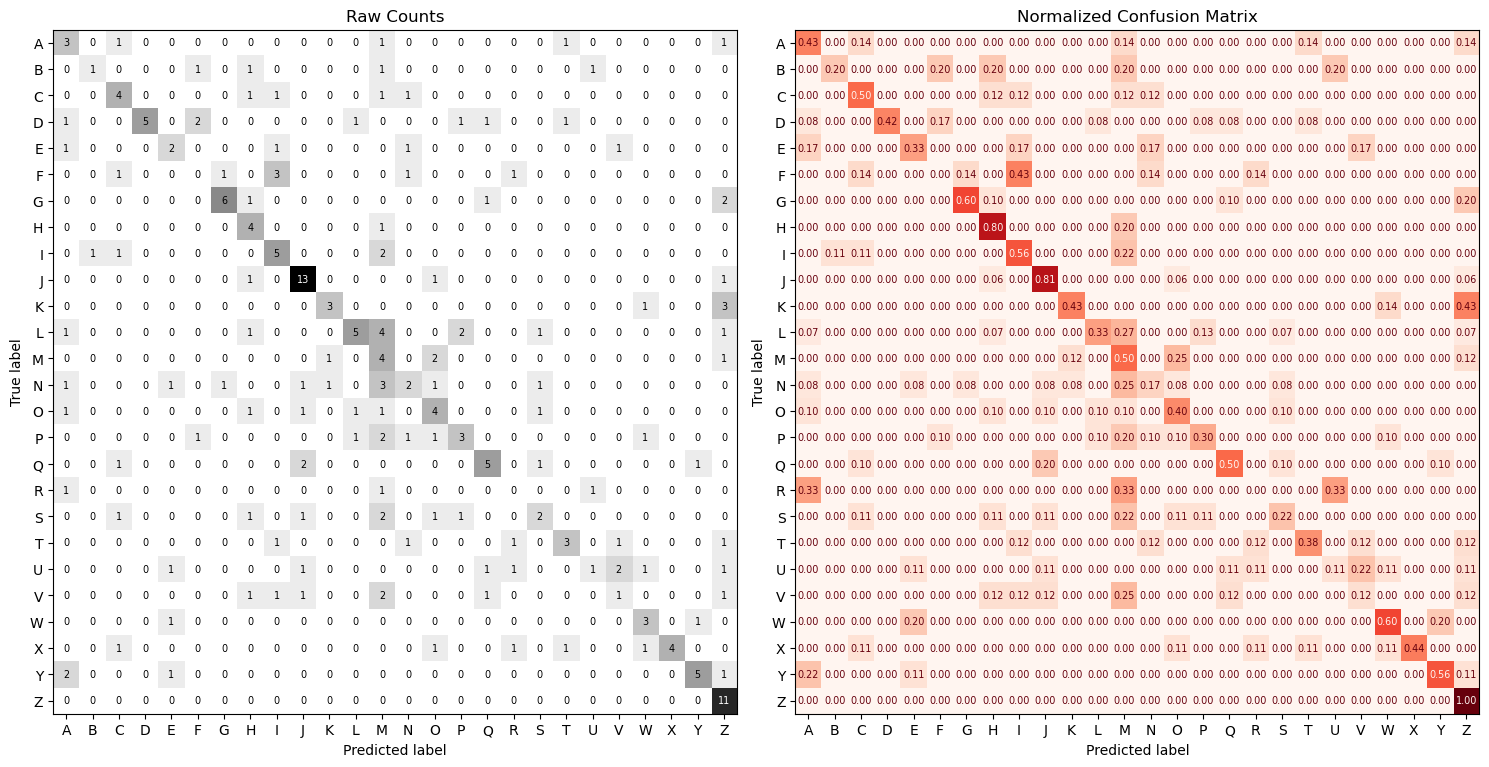

,precision,recall,f1-score
A,0.27,0.43,0.33
B,0.50,0.20,0.29
C,0.40,0.50,0.44
D,1.00,0.42,0.59
E,0.33,0.33,0.33
F,0.00,0.00,0.00
G,0.75,0.60,0.67
H,0.33,0.80,0.47
I,0.42,0.56,0.48
J,0.65,0.81,0.72



Overall Results:


,precision,recall,f1-score,support,accuracy
macro avg,0.447784,0.411867,0.398207,228.0,0.434211


INFO:tensorflow:Assets written to: modeling/models/towards-data-science-blog/assets
- Model saved to modeling/models/towards-data-science-blog
- Classification Report saved to modeling/models/towards-data-science-blog/classification_report.txt
- History figure saved to modeling/models/towards-data-science-blog/history.png
- Confusion Matrix figure saved to modeling/models/towards-data-science-blog/confusion_matrix.png
CPU times: user 28.9 s, sys: 10.2 s, total: 39.1 s
Wall time: 1min 24s


In [38]:
%%time
## Make, fit, and evaluate
model = make_model(model_name, show_summary=False, use_schedule=False)
model_results = fit_log_model(model, train_dataset, val_dataset, test_dataset, epochs=EPOCHS, patience=PATIENCE,
                              save_results=True,model_directory=model_dir)

#### Interpretation

- The first model is performing admirably, comparing ~51% accuracy with guessing the letter/class randomly (1/26 = 3.8% accuracy).

In [39]:
# Verify logs are working propery
logs_df = cf.logs.parse_log_file(log_file, clean_results=False)
logs_df


[i] Saved parsed logs to modeling/nn_training.csv


,INFO:root:,start_time,name,fit_time,precision,recall,f1-score,support,accuracy,model_save_fpath,save_classification_report_fpath,save_history_fpath,save_confusion_matrix_fpath
0,INFO:root:,06/05/2024 15:31:01,towards-data-science-blog,0:01:18.334031,0.447784,0.411867,0.398207,228.0,0.434211,modeling/models/towards-data-science-blog,modeling/models/towards-data-science-blog/clas...,modeling/models/towards-data-science-blog/hist...,modeling/models/towards-data-science-blog/conf...


In [40]:
logs_df = cf.logs.parse_log_file(log_file,clean_results=True)
logs_df


[i] Saved parsed logs to modeling/nn_training.csv


,Start Time,Name,Precision,Recall,F1-Score,Accuracy,Fit Time,Model Save Fpath
0,06/05/2024 15:31:01,towards-data-science-blog,0.448,0.412,0.398,0.434,0:01:18.334031,modeling/models/towards-data-science-blog


In [41]:
model_results['model_filepaths']['model_save_fpath']

'modeling/models/towards-data-science-blog'

In [42]:
# # testing loading models results
# loaded = cf.logs.load_model_results(model_fpath=model_results['model_filepaths']['model_save_fpath'],#model_name=logs_df.loc[0,'Name'], model_directory= FPATHS['modeling']['model_dir'],
#                             load_model=True)
# print(loaded.keys())
# loaded['model'].summary()


In [43]:
def delete_global_variable_if_exists(var_name: str):
    """
    # Example usage
    global_var = 20
    delete_global_variable_if_exists('global_var')
    print(global_var)  # This will raise a NameError if global_var was successfully deleted
    """
    if var_name in globals():
        del globals()[var_name]



In [44]:
# del model, loaded
for var in ['model', 'loaded']:
    delete_global_variable_if_exists(var)
    

## Model2

- Simpler CNN
- Using:
    - 1 Conv2D Layer:
        - Fitlers=16
        - Kernel Size= 3
        - Padding= 'same'
    - 1 MaxPooling later:
        - pool size -2

    - 1 Conv2D Layer:
        - Fitlers=32
        - Kernel Size= 3
        - Padding= 'same'
    - 1 MaxPooling later:
        - pool size -2

    - 0 Hidden Dense layers

    

In [45]:

def make_model2(name='CNN1',show_summary=False,use_schedule=False):
    
    model = models.Sequential(name=name)
    # Using rescaling layer to scale pixel values
    model.add(layers.Rescaling(1./255 , input_shape = (IMG_HEIGHT,IMG_WIDTH,3)))
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=32,  # How many filters you want to use
            kernel_size=3, # size of each filter
            # input_shape=input_shape,
            padding='same')) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling


    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=16,#64,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            # input_shape=input_shape,
            padding='same')) 
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling

    # Flattening layer
    model.add(layers.Flatten())
    model.add(layers.Dense(units = 512, activation = 'relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(
        layers.Dense(len(label_lookup), activation="softmax") )  
    
        
    ## JMI:
    if use_schedule:
        lr_schedule = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
        )  # 0.9)
        optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    else:
        optimizer = optimizers.legacy.Adam()#learning_rate=0.01)

    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    if show_summary:
        model.summary()
    return model

In [46]:
# model2 = make_model2(name="cnn1-fixed-lr", show_summary=True, use_schedule=False)
# model2_summary = capture_model_summary(model2)

# response = get_


Model: "cnn1-fixed-lr"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 16384)           

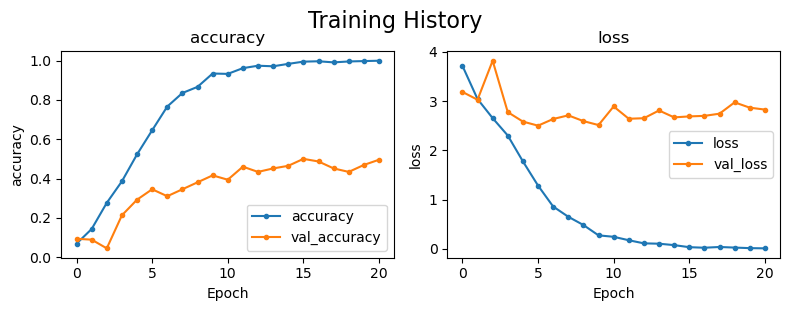


- Evaluating Test Data:
8/8 [==============================] - 0s 24ms/step - loss: 3.0015 - accuracy: 0.4079
{'loss': 3.0015339851379395, 'accuracy': 0.40789473056793213} 

--------------------------------------------------------------------------------
 Classification Metrics: Test Data 
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           A       0.29      0.29      0.29         7
           B       0.50      0.60      0.55         5
           C       0.33      0.38      0.35         8
           D       0.67      0.33      0.44        12
           E       0.14      0.33      0.20         6
           F       0.25      0.29      0.27         7
           G       0.86      0.60      0.71        10
           H       0.25      0.80      0.38         5
           I       0.36      0.44      0.40         9
           J       0.63      0.75      0.69        16
           K       0.50      0.7

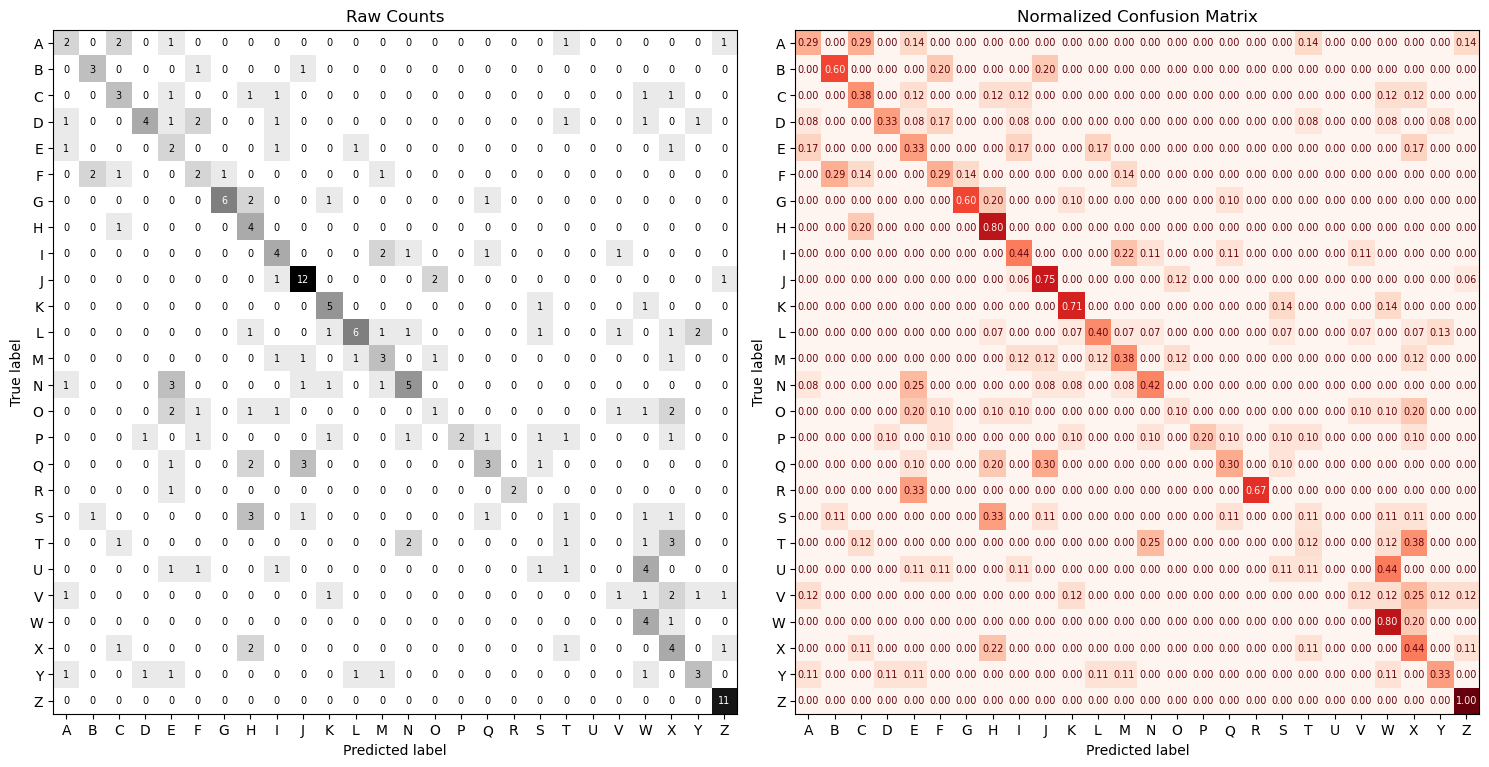

,precision,recall,f1-score
A,0.29,0.29,0.29
B,0.50,0.60,0.55
C,0.33,0.38,0.35
D,0.67,0.33,0.44
E,0.14,0.33,0.20
F,0.25,0.29,0.27
G,0.86,0.60,0.71
H,0.25,0.80,0.38
I,0.36,0.44,0.40
J,0.63,0.75,0.69



Overall Results:


,precision,recall,f1-score,support,accuracy
macro avg,0.422557,0.41569,0.38427,228.0,0.407895


INFO:tensorflow:Assets written to: modeling/models/cnn1-fixed-lr/assets
- Model saved to modeling/models/cnn1-fixed-lr
- Classification Report saved to modeling/models/cnn1-fixed-lr/classification_report.txt
- History figure saved to modeling/models/cnn1-fixed-lr/history.png
- Confusion Matrix figure saved to modeling/models/cnn1-fixed-lr/confusion_matrix.png


In [47]:
## Show model architecture
model2 = make_model2(name="cnn1-fixed-lr", show_summary=True, use_schedule=False)
model2_results = fit_log_model(model2, train_dataset, val_dataset, test_dataset, 
                               epochs=EPOCHS, patience=PATIENCE,
                              save_results=True,model_directory=model_dir)

### Adding LR Scheduling with Exponential Decay

Epoch 1/100
34/34 [==============================] - 2s 39ms/step - loss: 43.9656 - accuracy: 0.0369 - val_loss: 3.2582 - val_accuracy: 0.0354
Epoch 2/100
34/34 [==============================] - 1s 27ms/step - loss: 3.2738 - accuracy: 0.0369 - val_loss: 3.2598 - val_accuracy: 0.0310
Epoch 3/100
34/34 [==============================] - 1s 30ms/step - loss: 3.2548 - accuracy: 0.0340 - val_loss: 3.2575 - val_accuracy: 0.0310
Epoch 4/100
34/34 [==============================] - 1s 30ms/step - loss: 3.2511 - accuracy: 0.0416 - val_loss: 3.2567 - val_accuracy: 0.0310
Epoch 5/100
34/34 [==============================] - 1s 31ms/step - loss: 3.2477 - accuracy: 0.0444 - val_loss: 3.2574 - val_accuracy: 0.0265
Epoch 6/100
34/34 [==============================] - 1s 32ms/step - loss: 3.2473 - accuracy: 0.0406 - val_loss: 3.2582 - val_accuracy: 0.0265
Epoch 7/100
34/34 [==============================] - 1s 28ms/step - loss: 3.2454 - accuracy: 0.0529 - val_loss: 3.2570 - val_accuracy: 0.0265
Epoch

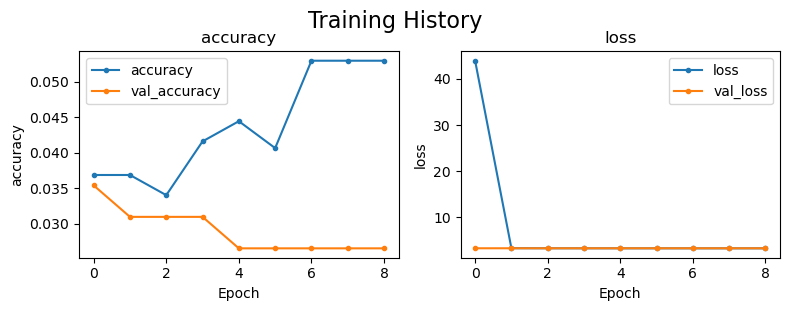


- Evaluating Test Data:
8/8 [==============================] - 0s 23ms/step - loss: 3.2547 - accuracy: 0.0395
{'loss': 3.2546796798706055, 'accuracy': 0.03947368264198303} 

--------------------------------------------------------------------------------
 Classification Metrics: Test Data 
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         7
           B       0.00      0.00      0.00         5
           C       0.00      0.00      0.00         8
           D       0.00      0.00      0.00        12
           E       0.00      0.00      0.00         6
           F       0.00      0.00      0.00         7
           G       0.00      0.00      0.00        10
           H       0.00      0.00      0.00         5
           I       0.00      0.00      0.00         9
           J       0.00      0.00      0.00        16
           K       0.00      0.0

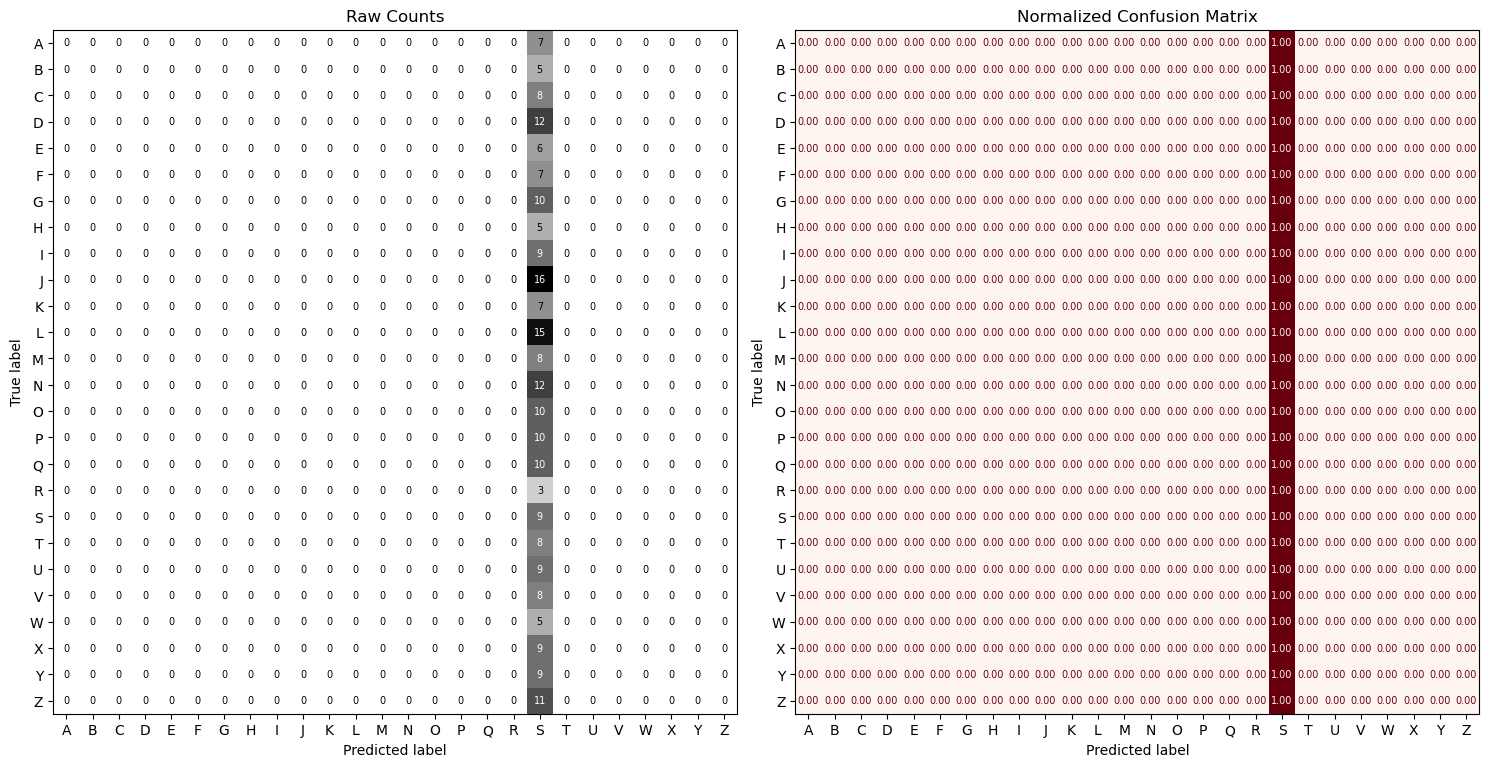

,precision,recall,f1-score
A,0.00,0.00,0.00
B,0.00,0.00,0.00
C,0.00,0.00,0.00
D,0.00,0.00,0.00
E,0.00,0.00,0.00
F,0.00,0.00,0.00
G,0.00,0.00,0.00
H,0.00,0.00,0.00
I,0.00,0.00,0.00
J,0.00,0.00,0.00



Overall Results:


,precision,recall,f1-score,support,accuracy
macro avg,0.001518,0.038462,0.002921,228.0,0.039474


INFO:tensorflow:Assets written to: modeling/models/cnn1-scheduled-lr/assets
- Model saved to modeling/models/cnn1-scheduled-lr
- Classification Report saved to modeling/models/cnn1-scheduled-lr/classification_report.txt
- History figure saved to modeling/models/cnn1-scheduled-lr/history.png
- Confusion Matrix figure saved to modeling/models/cnn1-scheduled-lr/confusion_matrix.png
CPU times: user 12.8 s, sys: 2.37 s, total: 15.1 s
Wall time: 14.9 s


In [48]:
%%time
model2_lr = make_model2(use_schedule=True, show_summary=False, name="cnn1-scheduled-lr")
model2_lr_results = fit_log_model(model2_lr, train_dataset, val_dataset, test_dataset, epochs=EPOCHS, patience=PATIENCE,
                              save_results=True,model_directory=model_dir)

del model2

## Transfer Learning



| Model             |   Size (MB) | Top-1 Accuracy   | Top-5 Accuracy   | Parameters   | Depth   | Time (ms) per inference step (CPU)   | Time (ms) per inference step (GPU)   |
|:------------------|------------:|:-----------------|:-----------------|:-------------|:--------|:-------------------------------------|:-------------------------------------|
| **VGG16**             |      528    | 71.3%            | 90.1%            | 138.4M       | 16      | 69.5                                 | 4.2                                  |
| **EfficientNetB0**    |       29    | 77.1%            | 93.3%            | 5.3M         | 132     | 46.0                                 | 4.9                                  |
| **InceptionV3**       |       92    | 77.9%            | 93.7%            | 23.9M        | 189     | 42.2                                 | 6.9                                  |

*Excerpt from Source: "https://keras.io/api/applications/"*

In [49]:
input_shape = (IMG_HEIGHT,IMG_WIDTH,3)
input_shape

(128, 128, 3)

### VGG16

In [50]:
# Downloading just the convolutional base
vgg16_base = tf.keras.applications.VGG16(
    include_top=False, weights="imagenet", input_shape=input_shape
)
# Prevent layers from base_model from changing 
vgg16_base.trainable = False

# Create the preprocessing lamdba layer
# Create a lambda layer for the preprocess input function for the model
lambda_layer_vgg16 = tf.keras.layers.Lambda(
    tf.keras.applications.vgg16.preprocess_input, name="preprocess_input"
)



def make_vgg16_model(name="VGG16",show_summary=False):
    model = models.Sequential(name=name)
    # Use input layer (lambda layer will handle rescaling).
    model.add(tf.keras.layers.Input(shape=input_shape))

    ## Adding preprocessing lamabda layer
    model.add(lambda_layer_vgg16)

    # Add pretrained base
    model.add(vgg16_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(len(label_lookup.values()), activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        # loss=tf.keras.losses.BinaryCrossentropy(),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    
    if show_summary:
        model.summary()
        
    return model


Epoch 1/100
34/34 [==============================] - 5s 136ms/step - loss: 10.2061 - accuracy: 0.1569 - val_loss: 2.6708 - val_accuracy: 0.2522
Epoch 2/100
34/34 [==============================] - 3s 101ms/step - loss: 2.4467 - accuracy: 0.3147 - val_loss: 2.4631 - val_accuracy: 0.2655
Epoch 3/100
34/34 [==============================] - 3s 101ms/step - loss: 2.1433 - accuracy: 0.4008 - val_loss: 2.3218 - val_accuracy: 0.3407
Epoch 4/100
34/34 [==============================] - 3s 103ms/step - loss: 1.7930 - accuracy: 0.4660 - val_loss: 2.2529 - val_accuracy: 0.4071
Epoch 5/100
34/34 [==============================] - 3s 103ms/step - loss: 1.6404 - accuracy: 0.5274 - val_loss: 2.0109 - val_accuracy: 0.4513
Epoch 6/100
34/34 [==============================] - 3s 102ms/step - loss: 1.5072 - accuracy: 0.5548 - val_loss: 1.8512 - val_accuracy: 0.5354
Epoch 7/100
34/34 [==============================] - 3s 97ms/step - loss: 1.4235 - accuracy: 0.5974 - val_loss: 1.8206 - val_accuracy: 0.5310

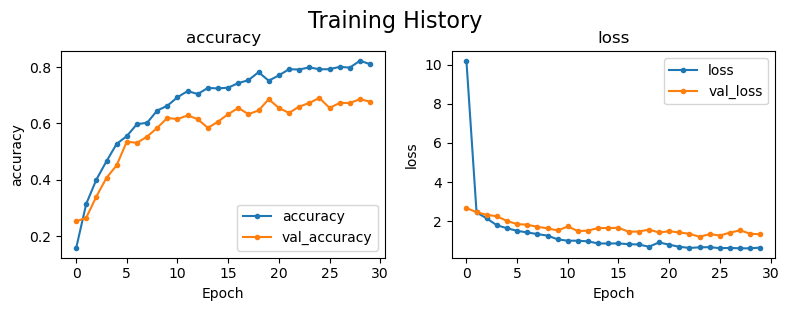


- Evaluating Test Data:
8/8 [==============================] - 1s 100ms/step - loss: 1.4469 - accuracy: 0.6447
{'loss': 1.4469126462936401, 'accuracy': 0.6447368264198303} 

--------------------------------------------------------------------------------
 Classification Metrics: Test Data 
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           A       0.50      0.57      0.53         7
           B       0.00      0.00      0.00         5
           C       0.75      0.75      0.75         8
           D       0.46      0.50      0.48        12
           E       0.50      0.50      0.50         6
           F       0.33      0.43      0.38         7
           G       0.86      0.60      0.71        10
           H       0.71      1.00      0.83         5
           I       0.40      0.89      0.55         9
           J       0.89      1.00      0.94        16
           K       0.57      0.5

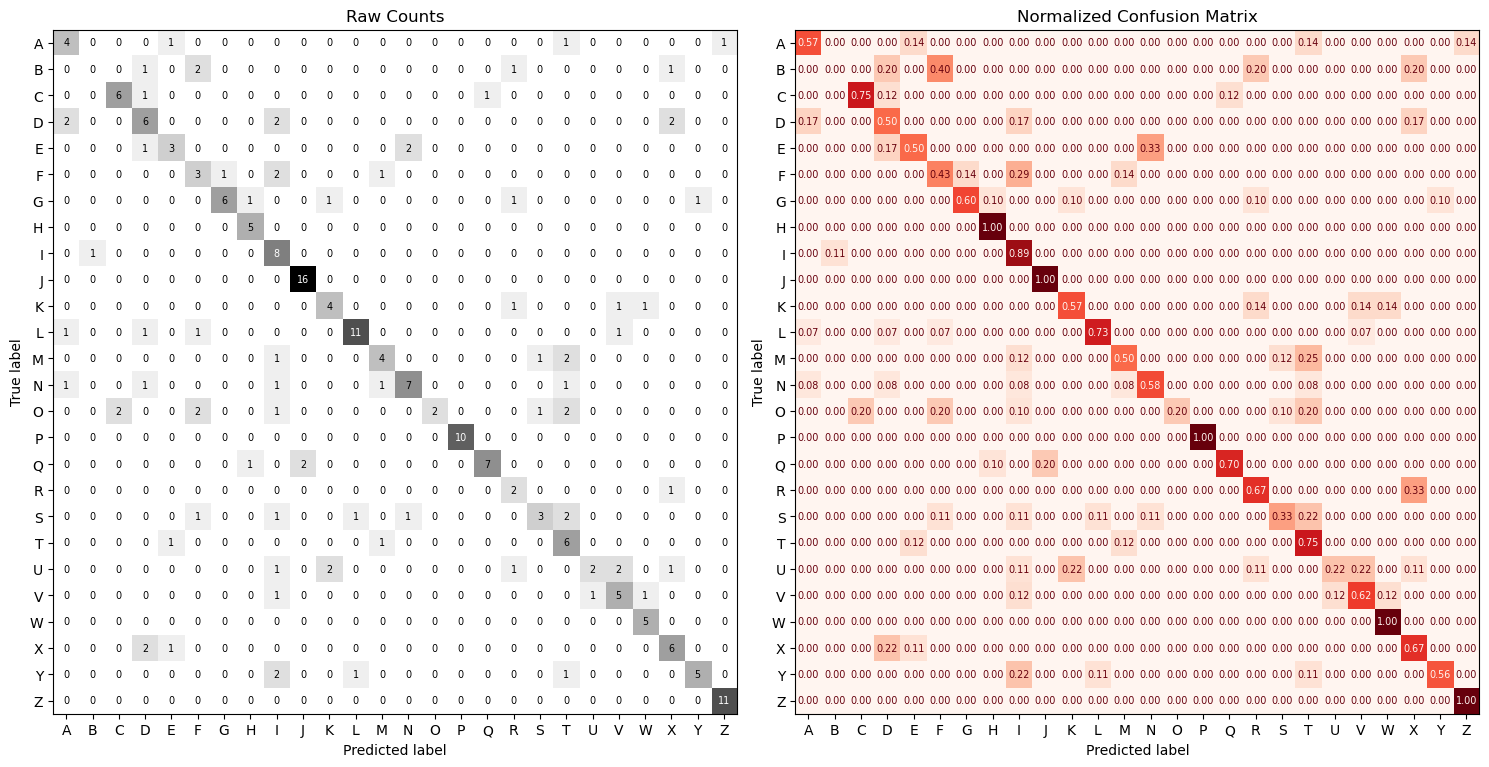

,precision,recall,f1-score
A,0.50,0.57,0.53
B,0.00,0.00,0.00
C,0.75,0.75,0.75
D,0.46,0.50,0.48
E,0.50,0.50,0.50
F,0.33,0.43,0.38
G,0.86,0.60,0.71
H,0.71,1.00,0.83
I,0.40,0.89,0.55
J,0.89,1.00,0.94



Overall Results:


,precision,recall,f1-score,support,accuracy
macro avg,0.635942,0.628709,0.603125,228.0,0.644737


INFO:tensorflow:Assets written to: modeling/models/VGG16-01/assets
- Model saved to modeling/models/VGG16-01
- Classification Report saved to modeling/models/VGG16-01/classification_report.txt
- History figure saved to modeling/models/VGG16-01/history.png
- Confusion Matrix figure saved to modeling/models/VGG16-01/confusion_matrix.png
CPU times: user 31.5 s, sys: 15.9 s, total: 47.5 s
Wall time: 1min 51s


In [51]:
%%time
# Baseline model
model_vgg = make_vgg16_model(name="VGG16-01", show_summary=False)
model_vgg_results = fit_log_model(model_vgg, train_dataset, val_dataset, test_dataset, epochs=EPOCHS, patience=PATIENCE,
                              save_results=True,model_directory=model_dir)
# history = model_vgg.fit(train_dataset,epochs = EPOCHS ,validation_data = val_dataset, callbacks=get_callbacks())

# results = custom_evaluate_classification_network(model_vgg,X_test=test_dataset,history=history, figsize=(15,15),
#                                                  target_names=label_lookup.values(),display_bar=True);


### EfficientNet

In [52]:
# Download EfficientNet base ## Changed to Netv2B0 to attempt to avoid error
efficientnet_base =tf.keras.applications.EfficientNetV2B0(include_top=False, 
                                                       input_shape=input_shape)
# efficientnet_base.summary()

In [53]:

# add preprocessing lambda layer
lambda_layer_efficient = tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input, 
                                      name='preprocess_input_enet',)


def make_efficientnet_model(name="EfficientNetB0",show_summary=True, use_schedule=False):
    model = models.Sequential(name=name)
    # Use input layer (lambda layer will handle rescaling).
    
    model.add(tf.keras.layers.Input(shape=input_shape))

    ## Adding preprocessing lamabda layer
    model.add(lambda_layer_efficient)

    # Add pretrained base
    model.add(efficientnet_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(len(label_lookup.values()), activation="softmax"))

        ## JMI:
    if use_schedule:
        lr_schedule = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
        )  # 0.9)
        optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    else:
        optimizer = optimizers.legacy.Adam()#learning_rate=0.01)


    
    model.compile(
        optimizer=optimizer,#tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    
    if show_summary:
        model.summary()
    return model

# vk.layered_view(efficientnet_base, legend=True)

Epoch 1/100
34/34 [==============================] - 33s 510ms/step - loss: 2.6741 - accuracy: 0.3412 - val_loss: 1.1802 - val_accuracy: 0.6681
Epoch 2/100
34/34 [==============================] - 4s 123ms/step - loss: 0.8865 - accuracy: 0.7552 - val_loss: 0.9654 - val_accuracy: 0.7035
Epoch 3/100
34/34 [==============================] - 4s 132ms/step - loss: 0.7190 - accuracy: 0.7949 - val_loss: 0.8965 - val_accuracy: 0.7124
Epoch 4/100
34/34 [==============================] - 4s 132ms/step - loss: 0.5533 - accuracy: 0.8440 - val_loss: 1.0009 - val_accuracy: 0.7522
Epoch 5/100
34/34 [==============================] - 4s 127ms/step - loss: 0.7132 - accuracy: 0.8053 - val_loss: 0.9795 - val_accuracy: 0.7035
Epoch 6/100
34/34 [==============================] - 4s 120ms/step - loss: 0.7078 - accuracy: 0.8062 - val_loss: 1.3254 - val_accuracy: 0.7080
Epoch 7/100
34/34 [==============================] - 4s 117ms/step - loss: 0.8717 - accuracy: 0.7987 - val_loss: 1.6973 - val_accuracy: 0.588

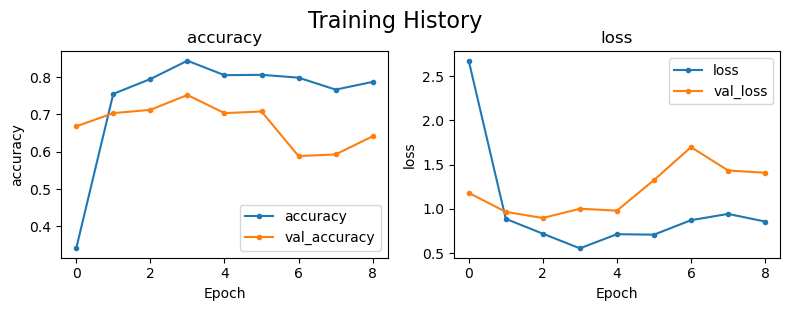


- Evaluating Test Data:
8/8 [==============================] - 2s 312ms/step - loss: 1.1096 - accuracy: 0.7105
{'loss': 1.1096421480178833, 'accuracy': 0.7105262875556946} 

--------------------------------------------------------------------------------
 Classification Metrics: Test Data 
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           A       0.75      0.86      0.80         7
           B       0.67      0.40      0.50         5
           C       0.64      0.88      0.74         8
           D       0.71      0.42      0.53        12
           E       0.50      0.67      0.57         6
           F       0.45      0.71      0.56         7
           G       1.00      0.60      0.75        10
           H       0.83      1.00      0.91         5
           I       0.57      0.89      0.70         9
           J       0.73      1.00      0.84        16
           K       1.00      0.4

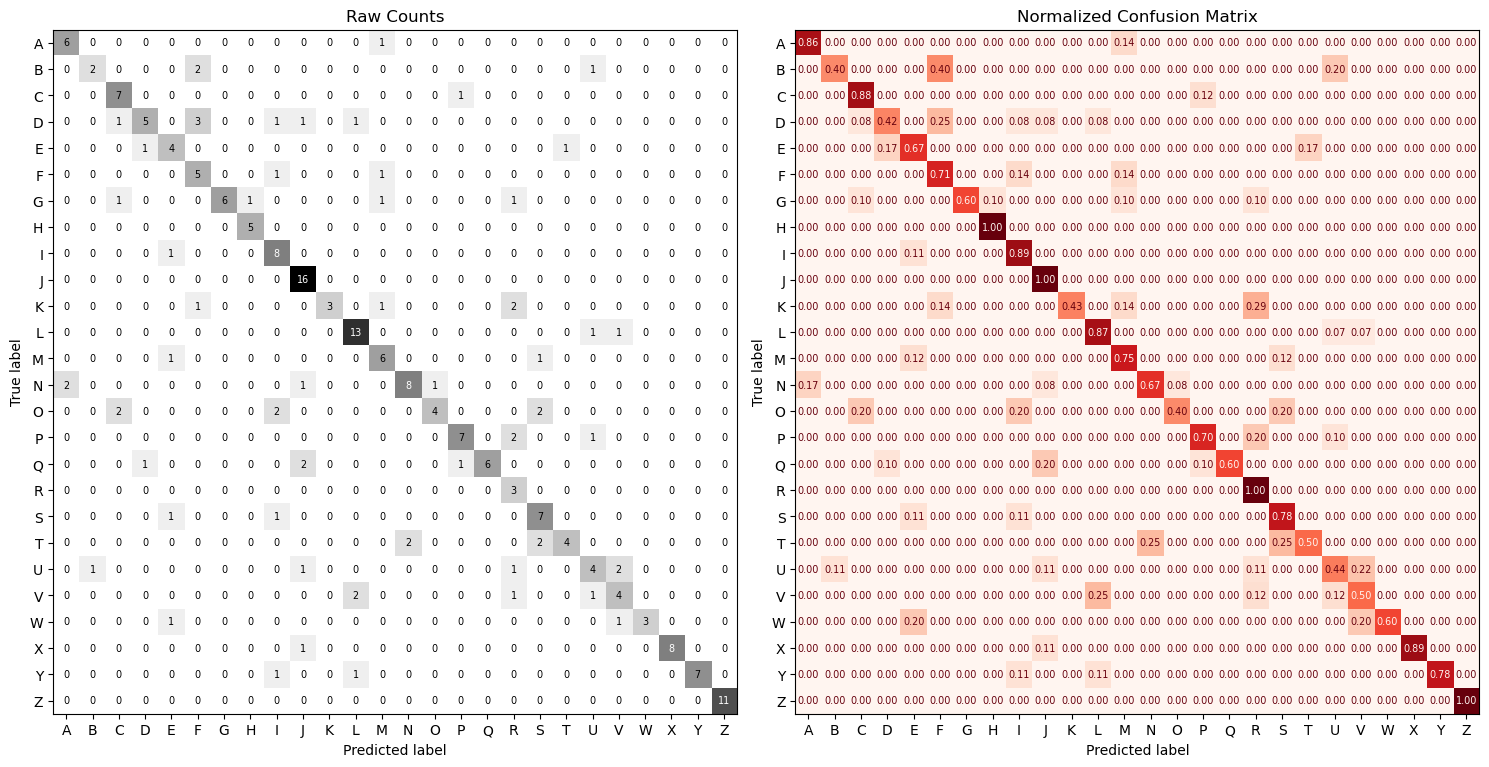

,precision,recall,f1-score
A,0.75,0.86,0.80
B,0.67,0.40,0.50
C,0.64,0.88,0.74
D,0.71,0.42,0.53
E,0.50,0.67,0.57
F,0.45,0.71,0.56
G,1.00,0.60,0.75
H,0.83,1.00,0.91
I,0.57,0.89,0.70
J,0.73,1.00,0.84



Overall Results:


,precision,recall,f1-score,support,accuracy
macro avg,0.741527,0.704594,0.692075,228.0,0.710526


KeyboardInterrupt: 

In [54]:
%%time
# Baseline model
model_eff = make_efficientnet_model(name="EfficientNetB0-1",show_summary=False, use_schedule=False)
model_eff_results = fit_log_model(model_eff, train_dataset, val_dataset, test_dataset, epochs=EPOCHS, patience=PATIENCE,
                              save_results=True,model_directory=model_dir)


In [ ]:
model_eff_results.keys()

In [ ]:
model_eff_results['results_classes']

In [ ]:
model_dir

In [ ]:
model_fpath = "modeling/models/EfficientNetB0-1/"
# Testing without recursion
folders_df = cf.fileinfo.list_files_in_directory(model_dir,#model_fpath,
                                                  return_df=True,
                                                  recursive=False, 
                                                  include_dir_details=True,
                                                  sort=True,
                                                  unit='MB')
folders_df#.set_index('Absolute Path')b

In [ ]:
model_fpath = "modeling/models/EfficientNetB0-1/"
filesize_df = cf.fileinfo.list_files_in_directory(model_fpath,sort=True)#,#model_fpath,
                                                #   recursive=True, return_df=True,
                                                # check_compatibility=True,
                                                  # sort=True, unit='MB')
filesize_df#.set_index('Absolute Path')

In [ ]:
model_fpath = "modeling/models/EfficientNetB0-1/"
filesize_df = cf.fileinfo.list_files_in_directory(model_dir,sort=True,#,#model_fpath,
                                                #   recursive=True, return_df=True,
                                                details=True,
                                                check_compatibility=True,
                                                  # sort=True, unit='MB'
                                                  )
filesize_df#.set_index('Absolute Path')

In [ ]:
## Check for large files (in model)
model_large_files = cf.fileinfo.list_files_in_directory(model_fpath,sort=True, only_large=True)
model_large_files

#### Using TFLiteConverter

In [ ]:
# # Convert the model to TensorFlow Lite format
# converter = tf.lite.TFLiteConverter.from_saved_model(model_fpath)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converter.convert()


# converted_model_fpath  = os.path.join(model_fpath, "model.tflite")
# print(converted_model_fpath)
# # # Save the quantized model
# # with open('model_quantized.tflite', 'wb') as f:
# #     f.write(tflite_model)


In [ ]:
# # Usng new quantize_model module
# help(cf.quantize_model)

In [ ]:
cf.show_code(cf.quantize_model)

In [ ]:
# model_eff_results.keys()

In [ ]:
model_fpath = "modeling/models/EfficientNetB0-1/"


### TO DO:
- [ ] Add a model_filepaths dictionary to model_results
```python
model_fpath = model_eff_results['model_filepaths']['model_save_fpath']
```


In [ ]:
# # # Convert the model to TensorFlow Lite format
# # model_fpath = model_eff_results['model_filepaths']['model_save_fpath']
# print(model_fpath)
# output_path = model_fpath.strip("/")+"_quantized.tflite"
# output_path

In [ ]:
# # %%time

# # Convert the model to quantized TensorFlow Lite format
# tflite_model = cf.quantize.convert_to_quantized_tflite(model_fpath, output_path, 
#                                                        representative_dataset=test_dataset,
#                                                        return_model=True)
# # tflite_model

In [ ]:
# cf.fileinfo.list_files_in_directory(FPATHS['modeling']['model_dir'],sort=True, only_large=False, recursive=True)

In [ ]:
# # Load the quantized model
# interpreter = cf.quantize.load_quantized_model(output_path)
# interpreter

In [ ]:

# # Prepare the input data for inference
# input_shape = interpreter.get_input_details()[0]['shape']
# input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)


In [ ]:
# input_shape = interpreter.get_input_details()[0]['shape']
# input_shape


In [ ]:
# input_details = interpreter.get_input_details()
# input_details

In [ ]:
# interpreter.set_tensor(input_details[0]['index'], input_data)


In [ ]:

# # Run inference
# output_data = cf.quantize.run_inference(interpreter, val_dataset.map(lambda x, y: x ))

### Testing Logs


In [ ]:
logs_df= cf.logs.parse_log_file(log_file)
logs_df

In [ ]:
results_df = logs_df.set_index("Model Save Fpath")
best_model_fpath = results_df['F1-Score'].idxmax()
best_model_fpath

In [ ]:
best_model_name = logs_df.set_index("Name")['F1-Score'].idxmax()
best_model_name

In [ ]:
best_model_fpath = logs_df.set_index("Model Save Fpath")['F1-Score'].idxmax()
best_model_fpath

In [ ]:
# loaded_model  =tf.keras.models.load_model(best_model_fpath)

In [ ]:

loaded = cf.logs.load_model_results(model_name=best_model_name,#logs_df.loc[0,'Name'],
                            model_directory= FPATHS['modeling']['model_dir'],
                            load_model=False # ISSUE WITH EFFICIENTNET
                            )
print(loaded.keys())
 # loaded['model'].summary()

In [ ]:
# model_eff.save(filepath=FPATHS['modeling']['best_transfer_fpaths']['model_dir'], save_format='tf')

In [ ]:
raise Exception("stop here.")

# Results

## Best Model

In [ ]:
BEST_MODEL = model_eff   #None

## Explaining Model Predictions with Lime

#### Convert test data to numpy arrays

In [ ]:
%%time
# timing WITH converting classes
y_test, y_hat_test, X_test = cf.get_true_pred_labels_images(BEST_MODEL,
                                                            test_dataset,
                                                            convert_y_for_sklearn=True)
y_test[0], y_hat_test[0]

In [ ]:
# label_lookup = {k:v.strip() for k,v in label_lookup.items()}

In [ ]:
# label_lookup

In [ ]:
i = 10
y_test[i]

## LimeExplainer

In [ ]:
# select an image index to use/view
i = 8

# Show actual-sized image with keras
display(array_to_img(X_test[i]))
print(f"True Label: {label_lookup[y_test[i]]}")
print(f"Predicted: {label_lookup[y_hat_test[i]]}")

### To Do:
- Fix the comparison images below 

In [ ]:
from skimage.segmentation import mark_boundaries
from lime import lime_image

In [ ]:
explainer = lime_image.LimeImageExplainer(verbose=True,random_state=321)
explainer

In [ ]:
label= label_lookup[y_test[i]]
label

In [ ]:
array_to_img(X_test[i])

In [ ]:
# Get the explanation object for the chosen
explanation = explainer.explain_instance(X_test[i], # Convert image values to ints    
                                         BEST_MODEL.predict, # Prediction method/function
                                         top_labels=2, # How many of the labels to explain [?]
                                         hide_color=0, #
                                         num_samples=1000,
                                        )

In [ ]:
array_to_img(explanation.image)

In [ ]:
explanation.image.max()

In [ ]:
# Stored original image
plt.imshow(explanation.image.astype(int));
plt.axis('off');

In [ ]:
# Explanation split image into "segments"
plt.imshow(explanation.segments); 

In [ ]:
# Unique Segments
len(np.unique(explanation.segments))

In [ ]:
[label_lookup[k] for k in  explanation.top_labels]

In [ ]:
label_lookup[y_test[i]]

In [ ]:
# Get the explanation for the top label
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Display the original image with the explanation
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')
plt.show()

In [ ]:
#pros and cons
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=10, 
                                            hide_rest=False
                                           )
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')
plt.title('Segments that Positively Pushed Prediction');

In [ ]:
#pros and cons
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            negative_only=True, 
                                            positive_only=False,
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')

In [ ]:
temp.max() * 255

In [ ]:
plt.imshow(temp/255.)

In [ ]:
label_lookup

In [ ]:
# JMI AND CHRIS
pred_probs = BEST_MODEL.predict(X_test[i].reshape(1,IMG_HEIGHT,IMG_WIDTH,3))
pred_probs_dict = dict(zip(label_lookup.values(), pred_probs[0]))
pred_probs_df = pd.Series(pred_probs_dict).round(2).sort_values(ascending=False)
pred_probs_df


In [ ]:
#pros and cons
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            negative_only=False, 
                                            positive_only=False,
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp/255.0, mask))
plt.axis('off')
plt.title(f'Segments that Pushed Prediction Towards (Green) or Away (Red) from {label}');

In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

from IPython.display import clear_output

def plot_comparison(main_image, img, mask):
    """Adapted from Source:
    https://coderzcolumn.com/tutorials/artificial-intelligence/lime-explain-keras-image-classification-network-predictions"""
    fig,axes = plt.subplots(ncols=4,figsize=(15,5))

    img = img / 255.0
    # show original image
    ax = axes[0]
    ax.imshow(main_image.astype(int))#, cmap="gray");
    ax.set_title("Original Image")
    ax.axis('off')

    ax =axes[1]
    ax.imshow(img)#g.astype(int) )#.astype(int));
    ax.set_title("Image")
    ax.axis('off')
    
    ax = axes[2]
    ax.imshow(mask);
    ax.set_title("Mask")
    ax.axis('off')
    
    ax = axes[3]
    
    ax.imshow(mark_boundaries(img,
                              mask, color=(0,1,0)));
    ax.set_title("Image+Mask Combined");
    ax.axis('off')
    fig.tight_layout()
    

In [ ]:
temp

In [ ]:
plot_comparison(X_test[i], temp, mask)

### Explaining an Incorrect Prediction

In [ ]:


idx_incorrect =  y_hat_test != y_test
idx_incorrect

In [ ]:
X_test_wrong = X_test[idx_incorrect]
y_test_wrong = y_test[idx_incorrect]
y_hat_test_wrong = y_hat_test[idx_incorrect]

In [ ]:
# select an image index to use/view
i = 8

# Show actual-sized image with keras
display(array_to_img(X_test_wrong[i]))
print(f"True Label: {label_lookup[y_test_wrong[i]]}")
print(f"Predicted: {label_lookup[y_hat_test[i]]}")

In [ ]:
# Get the explanation object for the chosen
explanation = explainer.explain_instance(X_test_wrong[i], # Convert image values to ints    
                                         BEST_MODEL.predict, # Prediction method/function
                                         top_labels=2, # How many of the labels to explain [?]
                                         hide_color=0, #
                                         num_samples=1000,
                                        )

In [ ]:
#pros and cons

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            negative_only=False, 
                                            positive_only=False,
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp/255.0, mask))
plt.axis('off')
plt.title(f'Segments that Pushed Prediction Towards (Green) or Away (Red) from {label}');

### Explaining Letters Often Confused

y_hat_test

In [ ]:
confused_labels = ["U","V"]


In [ ]:
label_index_lookup ={v:k for k,v in label_lookup.items()}
label_index_lookup

In [ ]:
[label_index_lookup[l] for l in confused_labels]

In [ ]:
is_u = y_test == label_index_lookup['U']
pred_v = y_hat_test == label_index_lookup['V']

is_v = y_test == label_index_lookup['V']


In [ ]:
idx_mistaken = is_u & pred_v
idx_mistaken

In [ ]:
X_test_mistaken = X_test[idx_mistaken]
y_test_mistaken = y_test[idx_mistaken]
y_hat_test_mistaken = y_hat_test[idx_mistaken]
X_test_mistaken.shape

In [ ]:
# X_test_u = X_test[is_u]
# y_test_u = y_test[is_u]
# y_hat_test_u = y_hat_test[is_u]

# X_test_v = X_test[is_v]
# y_test_v = y_test[is_v]
# y_hat_test_v = y_hat_test[is_v]

In [ ]:
i = 0


print(f"True Label: {label_lookup[y_test_mistaken[i]]}")
print(f"Predicted: {label_lookup[y_hat_test_mistaken[i]]}")
display(array_to_img(X_test_mistaken[i]))

In [ ]:
# Get the explanation object for the chosen
explanation = explainer.explain_instance(X_test_mistaken[i], # Convert image values to ints    
                                         BEST_MODEL.predict, # Prediction method/function
                                         top_labels=2, # How many of the labels to explain [?]
                                         hide_color=0, #
                                         num_samples=1000,
                                        )

In [ ]:
# label_index_lookup

In [ ]:
[label_lookup[l] for l in explanation.top_labels]

In [ ]:
#pros and cons

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            negative_only=False, 
                                            positive_only=False,
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp/255.0, mask))
plt.axis('off')
plt.title(f'Segments that Pushed Prediction Towards (Green) or Away (Red) from {label}');

# Work-in-Progress

In [ ]:
raise Exception("stop here")

### Quantizing Model

> Added new functions in fileinfo module in custom_functions.

In [ ]:
# raise Exception("Results work below moved to README maker notebook.")

## PREPARE TABLE FOR README

In [ ]:

# logs_df = parse_log_file(log_file,clean_results=True      )
# readme_logs = logs_df.drop(columns=['Start Time'], errors='ignore')
# readme_logs = readme_logs.set_index('Name')
# readme_logs

In [ ]:
# FPATHS['readme']['resul']

In [ ]:
# results_md_file = FPATHS['readme']['results_table_md']
# readme_logs.to_markdown(results_md_file)


### To Do:  generate readme from results

In [ ]:
# from IPython.display import Markdown
# with open(results_md_file) as f:
#     loaded_results = f.read()
# display(Markdown(loaded_results))
    

In [ ]:
# readme_logs['duration'] = pd.to_timedelta(readme_logs['fit_time'],)

# readme_logs

# APPENDIX/WIP

## Keras Tuner - best model

In [ ]:
import keras_tuner as kt
from keras_tuner import HyperParameters as hp
hp

In [ ]:
n_units = hp.Int('units', min_value=32, max_value=512, step=32)
dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)   

In [ ]:

# add preprocessing lambda layer
lambda_layer_efficient = tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input, 
                                      name='preprocess_input_enet',)


def tune_efficientnet_model(hp):
    name="EfficientNetB0" 
    input_shape = (IMG_HEIGHT,IMG_WIDTH,3)
    n_units = hp.Int('units', min_value=32, max_value=512, step=32)
    dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)   
    use_schedule = hp.Boolean('use_schedule')
    
    model = models.Sequential(name=name)
    # Use input layer (lambda layer will handle rescaling).
    
    model.add(tf.keras.layers.Input(shape=input_shape))

    ## Adding preprocessing lamabda layer
    model.add(lambda_layer_efficient)

    # Add pretrained base
    model.add(efficientnet_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(n_units, activation="relu"))
    model.add(layers.Dropout(dropout))

    # Output layer
    model.add(layers.Dense(len(label_lookup.values()), activation="softmax"))

        ## JMI:
    if use_schedule:
        lr_schedule = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
        )  # 0.9)
        optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    else:
        optimizer = optimizers.legacy.Adam()#learning_rate=0.01)


    
    model.compile(
        optimizer=optimizer,#tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    

    return model

# vk.layered_view(efficientnet_base, legend=True)

In [ ]:
#hyperband allows for callbacks
tuner_hb = kt.Hyperband(tune_efficientnet_model, objective='val_accuracy',
                        max_epochs=20, overwrite=True)
tuner_hb.search_space_summary()


In [ ]:
tuner_hb.search(train_dataset,validation_data=val_dataset,epochs=20)
                # callbacks=[tf.keras.callbacks.TensorBoard("/tmp/tb_logs")])
best_hp = tuner_hb.get_best_hyperparameters()[0]
print(best_hp)

In [ ]:
# best_model  = tuner_hb.get_best_models()[0]
# show_layers(best_model)

In [ ]:
best_params = tuner_hb.get_best_hyperparameters()[0]
best_model = tuner_hb.get_best_models()[0]
print(f'Best Params:\n ',best_params)
cf.evaluate_classification_network(best_model, X_test=test_dataset, figsize=(15,15),
                                    target_names=label_lookup.values())#,display_bar=True);

## To Do: Keras Tuner

In [ ]:
# ## Fit and evaluate model with custom function
# model2 = make_model2()
# history2 = model2.fit(train_dataset,epochs = 100 ,validation_data = val_dataset, callbacks=get_callbacks())
# results_dict = custom_evaluate_classification_network(model2,X_test=test_dataset,history=history2, figsize=(15,15), 
#                                                       target_names=label_lookup.values(),
#                                                       as_frame=True, frame_include_macro_avg=False, frame_include_support=False,
#                                                       display_bar=True)

In [ ]:
# raise Exception("
# Do not run below yet.")